In [814]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [815]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'oc1'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196'

TARGETNAME = 'placement'

In [816]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_matches.pickle'))

In [817]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,Set7_Guild,...,TFT7_Lillia_item2,TFT7_Braum_item2,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Aatrox_item2
0,OC1_526860514,3,TFT7_Augment_GuildEmblem2,TFT6_Augment_CelestialBlessing2,TFT6_Augment_VerdantVeil,0.0,1.0,1.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OC1_526860514,1,TFT7_Augment_CavalierEmblem2,TFT6_Augment_Electrocharge2,TFT6_Augment_VerdantVeil,1.0,2.0,NaN,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OC1_526860514,2,TFT7_Augment_LivingForge,TFT6_Augment_Diversify2,TFT6_Augment_RadiantRelics,NaN,NaN,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OC1_526860514,5,TFT7_Augment_DragonmancerEmblem2,TFT7_Augment_DragonmancerInspire,TFT7_Augment_ThinkFast,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OC1_526860514,8,TFT6_Augment_BandOfThieves2,TFT6_Augment_PortableForge,TFT6_Augment_GrandGambler,0.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,OC1_526512732,5,TFT6_Augment_SalvageBin,TFT6_Augment_ForceOfNature,TFT6_Augment_SecondWind2,1.0,0.0,NaN,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2780,OC1_526512732,4,TFT6_Augment_TradeSector,TFT6_Augment_HighEndShopping,TFT6_Augment_CelestialBlessing2,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2781,OC1_526512732,2,TFT6_Augment_ClearMind,TFT7_Augment_UrfsGrabBag2,TFT6_Augment_ThrillOfTheHunt2,1.0,0.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2782,OC1_526512732,7,TFT7_Augment_MageConference,TFT7_Augment_MageEmblem2,TFT6_Augment_Meditation2,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [818]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [819]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to  4.73 Mb (16.6% reduction)


In [820]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,Set7_Guild,...,TFT7_Lillia_item2,TFT7_Braum_item2,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Aatrox_item2
1,OC1_526860514,1,TFT7_Augment_CavalierEmblem2,TFT6_Augment_Electrocharge2,TFT6_Augment_VerdantVeil,1.0,2.0,NaN,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OC1_526860514,2,TFT7_Augment_LivingForge,TFT6_Augment_Diversify2,TFT6_Augment_RadiantRelics,NaN,NaN,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OC1_526860514,5,TFT7_Augment_DragonmancerEmblem2,TFT7_Augment_DragonmancerInspire,TFT7_Augment_ThinkFast,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OC1_526860514,8,TFT6_Augment_BandOfThieves2,TFT6_Augment_PortableForge,TFT6_Augment_GrandGambler,0.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,OC1_526860514,7,TFT6_Augment_CyberneticImplants3,TFT6_Augment_CelestialBlessing2,TFT6_Augment_RadiantRelics,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,OC1_526512732,5,TFT6_Augment_SalvageBin,TFT6_Augment_ForceOfNature,TFT6_Augment_SecondWind2,1.0,0.0,NaN,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2780,OC1_526512732,4,TFT6_Augment_TradeSector,TFT6_Augment_HighEndShopping,TFT6_Augment_CelestialBlessing2,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2781,OC1_526512732,2,TFT6_Augment_ClearMind,TFT7_Augment_UrfsGrabBag2,TFT6_Augment_ThrillOfTheHunt2,1.0,0.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2782,OC1_526512732,7,TFT7_Augment_MageConference,TFT7_Augment_MageEmblem2,TFT6_Augment_Meditation2,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [821]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [822]:
# Check NA
check_NA(raw_df)

augment1                      3
augment2                     16
Set7_Assassin              1784
Set7_Cavalier              1734
Set7_Dragon                1310
                           ... 
TFT7_Heimerdinger_item1    2775
TFT7_Heimerdinger_item2    2780
TFT7_Vladimir_item1        2781
TFT7_Vladimir_item2        2782
TFT7_Aatrox_item2          2781
Length: 264, dtype: int64


In [823]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [824]:
raw_df = impute(raw_df)

In [825]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [826]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [827]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
OC1_526860514    8
OC1_526482459    8
OC1_526327966    8
OC1_526546393    8
OC1_526356222    8
                ..
OC1_526713243    8
OC1_526714194    8
OC1_526712268    8
OC1_526711746    8
OC1_526512732    8
Name: match_id, Length: 348, dtype: int64 

augment0
TFT6_Augment_PortableForge             110
TFT7_Augment_UrfsGrabBag1               88
TFT6_Augment_Weakspot                   77
TFT6_Augment_SecondWind1                77
TFT6_Augment_Ascension                  77
                                      ... 
TFT7_Augment_TempestEmblem2              1
TFT6_Augment_FuturePeepers               1
TFT7_Augment_CavalierForAllUnits         1
TFT7_Augment_AstralIntercosmicGifts      1
TFT7_Augment_ShimmerscaleTrait2          1
Name: augment0, Length: 167, dtype: int64 

augment1
TFT6_Augment_SecondWind1                  142
TFT6_Augment_Weakspot                      98
TFT6_Augment_TinyTitans                    86
TFT6_Augment

In [828]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [829]:
raw_df.describe()

,placement,Set7_Assassin,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,Set7_Guild,Set7_Mirage,Set7_Ragewing,Set7_Swiftshot,Set7_Warrior,...,TFT7_AoShin,TFT7_Kayn,TFT7_Varus,TFT7_AurelionSol,TFT7_Shyvana,TFT7_Taric,TFT7_Senna,TFT7_TahmKench,TFT7_Aatrox,TFT7_Ezreal
count,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,...,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000
mean,4.500000,0.357399,0.321480,0.544181,0.424928,1.089440,0.212284,0.466236,0.322557,0.207256,...,0.071480,0.081897,0.035201,0.010057,0.138649,0.088003,0.012572,0.058908,0.022270,0.072198
std,2.291699,0.672168,0.690596,0.528921,0.784395,1.271418,0.742804,0.649726,0.494433,0.427837,...,0.338443,0.383512,0.311794,0.113289,0.450369,0.443518,0.149931,0.328511,0.202942,0.395123
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.250000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,3.000000,4.000000,2.000000,3.000000,6.000000,4.000000,3.000000,3.000000,2.000000,...,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000


In [830]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Columns: 267 entries, match_id to TFT7_Aatrox_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 4.7+ MB


2022-06-29 12:52:48,272 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


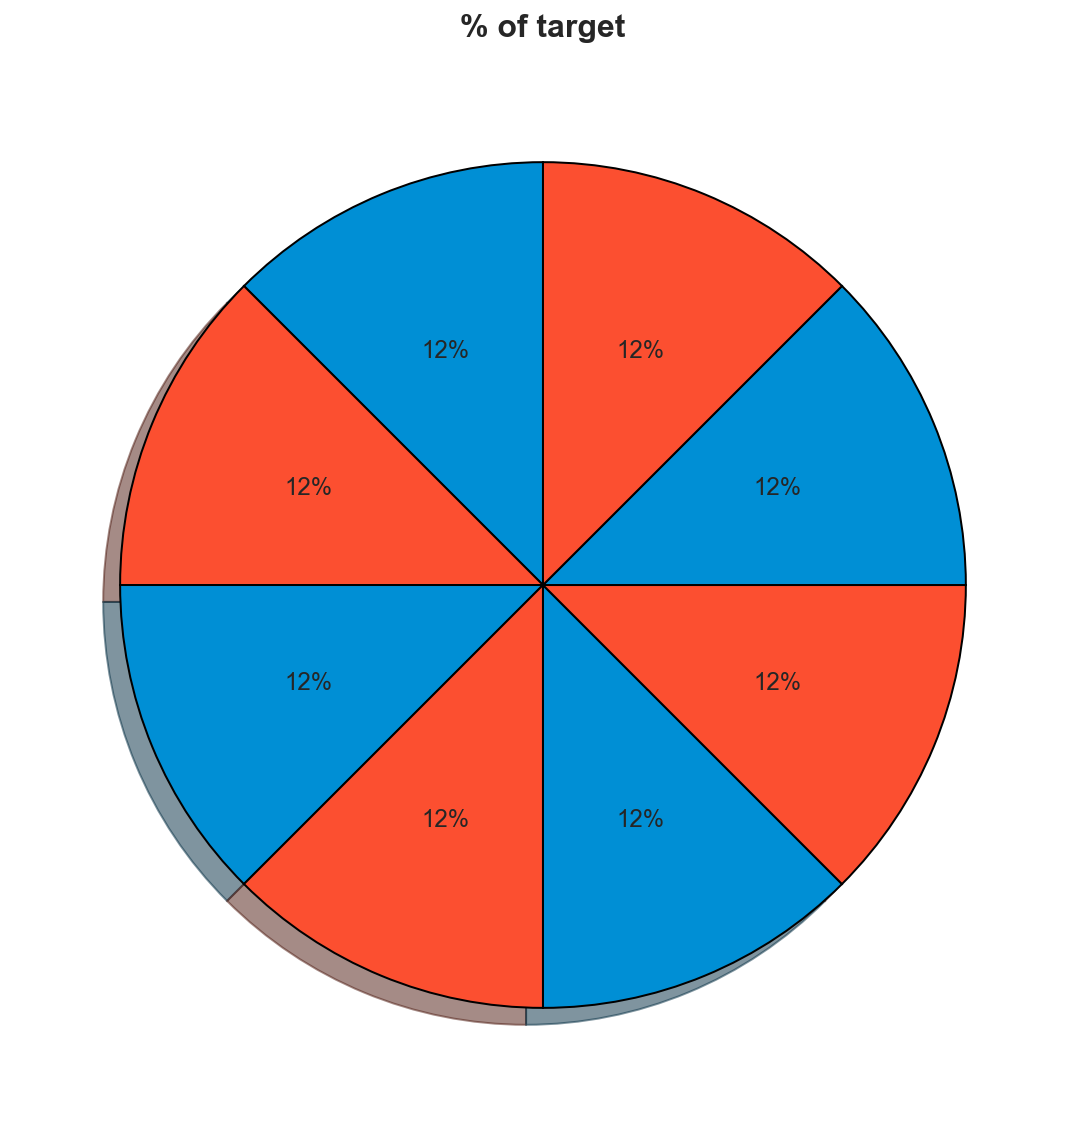

In [831]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [832]:
X = raw_df.drop(['match_id'], axis=1)


In [833]:
y = X.pop(TARGETNAME)

In [834]:
X.fillna('', inplace=True)

In [835]:
X.dtypes

augment0                    object
augment1                    object
augment2                    object
Set7_Assassin              float32
Set7_Cavalier              float32
                            ...   
TFT7_Heimerdinger_item1     object
TFT7_Heimerdinger_item2     object
TFT7_Vladimir_item1         object
TFT7_Vladimir_item2         object
TFT7_Aatrox_item2           object
Length: 265, dtype: object

In [836]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [837]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [838]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [839]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Columns: 265 entries, augment0 to TFT7_Aatrox_item2
dtypes: int64(87), object(178)
memory usage: 5.6+ MB


In [840]:
X

,augment0,augment1,augment2,Set7_Assassin,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,Set7_Guild,Set7_Mirage,Set7_Ragewing,...,TFT7_Lillia_item2,TFT7_Braum_item2,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Aatrox_item2
0,TFT7_Augment_GuildEmblem2,TFT6_Augment_CelestialBlessing2,TFT6_Augment_VerdantVeil,0,1,1,0,4,3,0,...,,,,,,,,,,
1,TFT7_Augment_CavalierEmblem2,TFT6_Augment_Electrocharge2,TFT6_Augment_VerdantVeil,1,2,0,0,3,0,1,...,,,,,,,,,,
2,TFT7_Augment_LivingForge,TFT6_Augment_Diversify2,TFT6_Augment_RadiantRelics,0,0,1,0,1,0,0,...,,,,,,,,,,
3,TFT7_Augment_DragonmancerEmblem2,TFT7_Augment_DragonmancerInspire,TFT7_Augment_ThinkFast,0,0,0,2,0,0,0,...,,,,,,,,,,
4,TFT6_Augment_BandOfThieves2,TFT6_Augment_PortableForge,TFT6_Augment_GrandGambler,0,0,1,0,0,0,0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,TFT6_Augment_SalvageBin,TFT6_Augment_ForceOfNature,TFT6_Augment_SecondWind2,1,0,0,0,4,0,0,...,,,,,,,,,,
2780,TFT6_Augment_TradeSector,TFT6_Augment_HighEndShopping,TFT6_Augment_CelestialBlessing2,0,0,1,0,0,0,0,...,,,,,,,,,,
2781,TFT6_Augment_ClearMind,TFT7_Augment_UrfsGrabBag2,TFT6_Augment_ThrillOfTheHunt2,1,0,1,0,3,0,2,...,,,,,,,,,,
2782,TFT7_Augment_MageConference,TFT7_Augment_MageEmblem2,TFT6_Augment_Meditation2,0,0,1,0,0,0,0,...,,,,,,,,,,


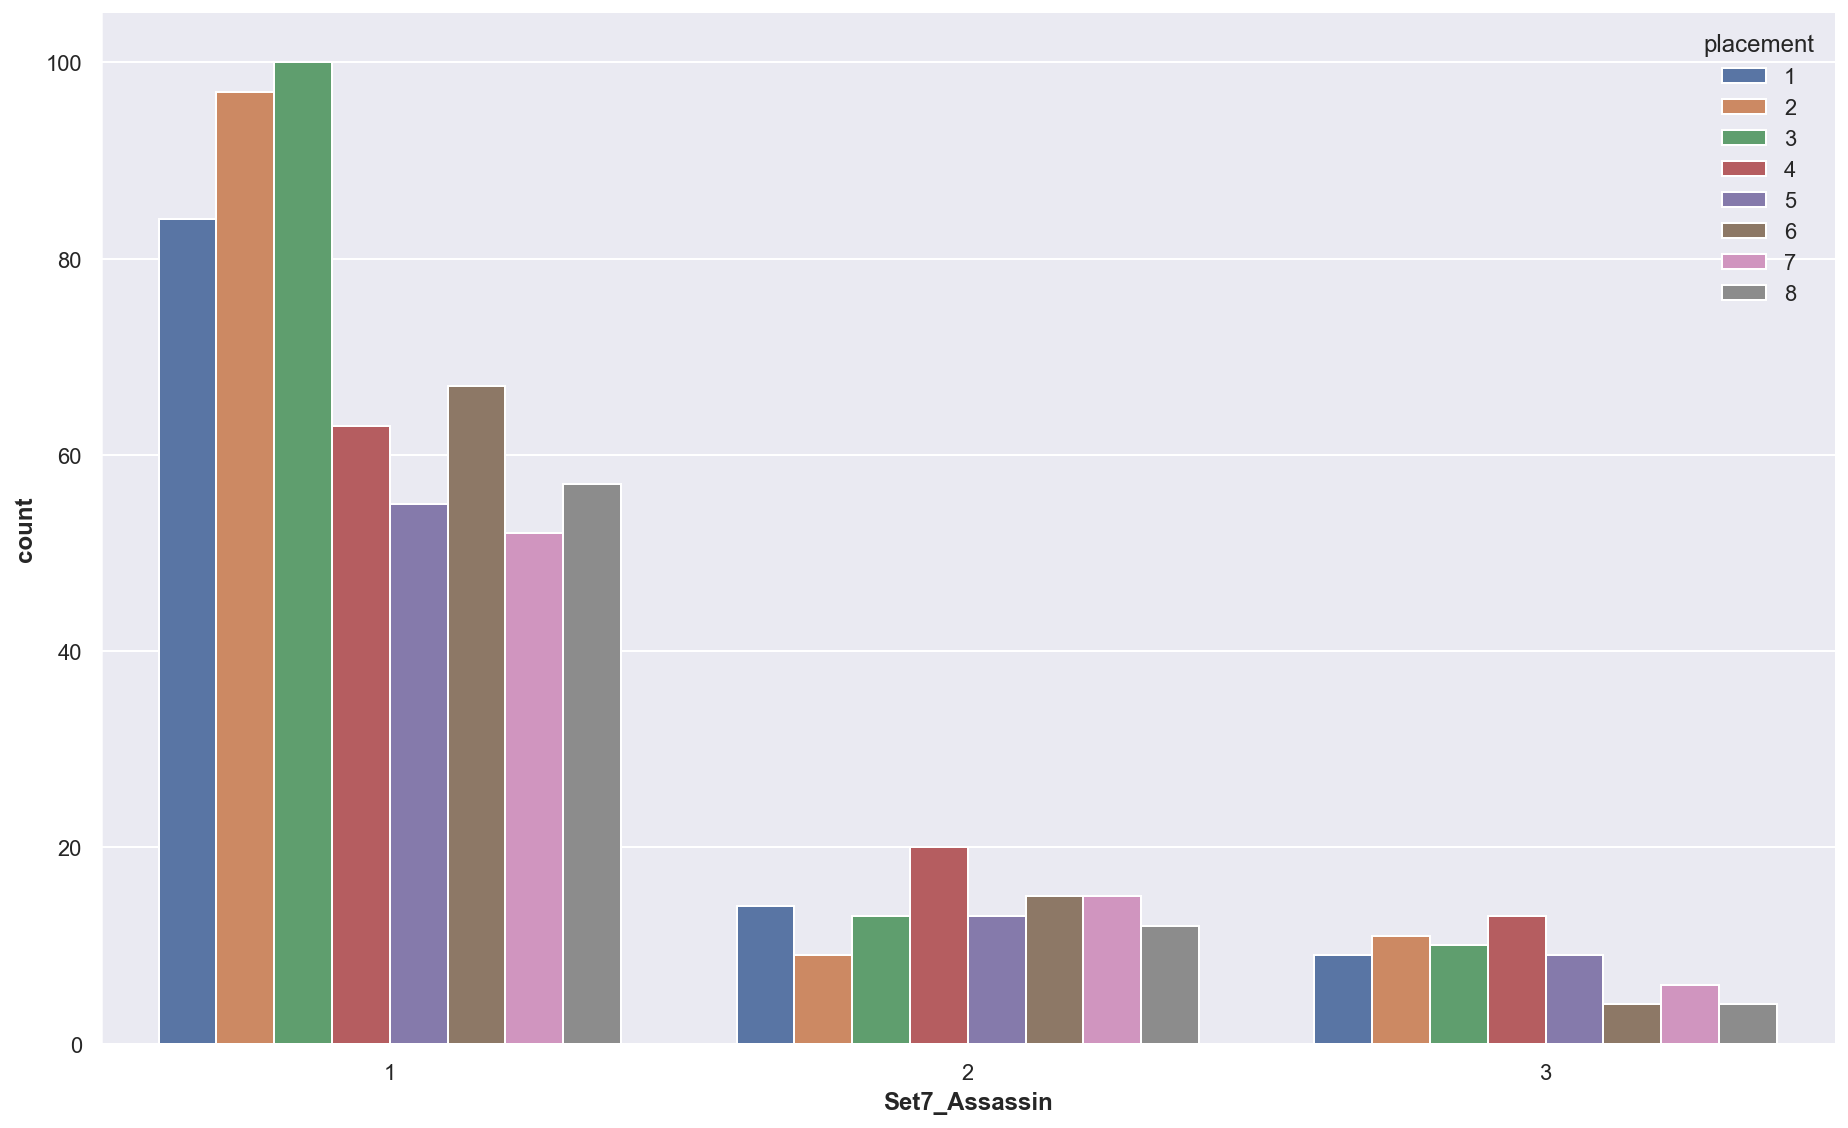

In [841]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Assassin']>0], x='Set7_Assassin', hue=TARGETNAME)
sns.despine()

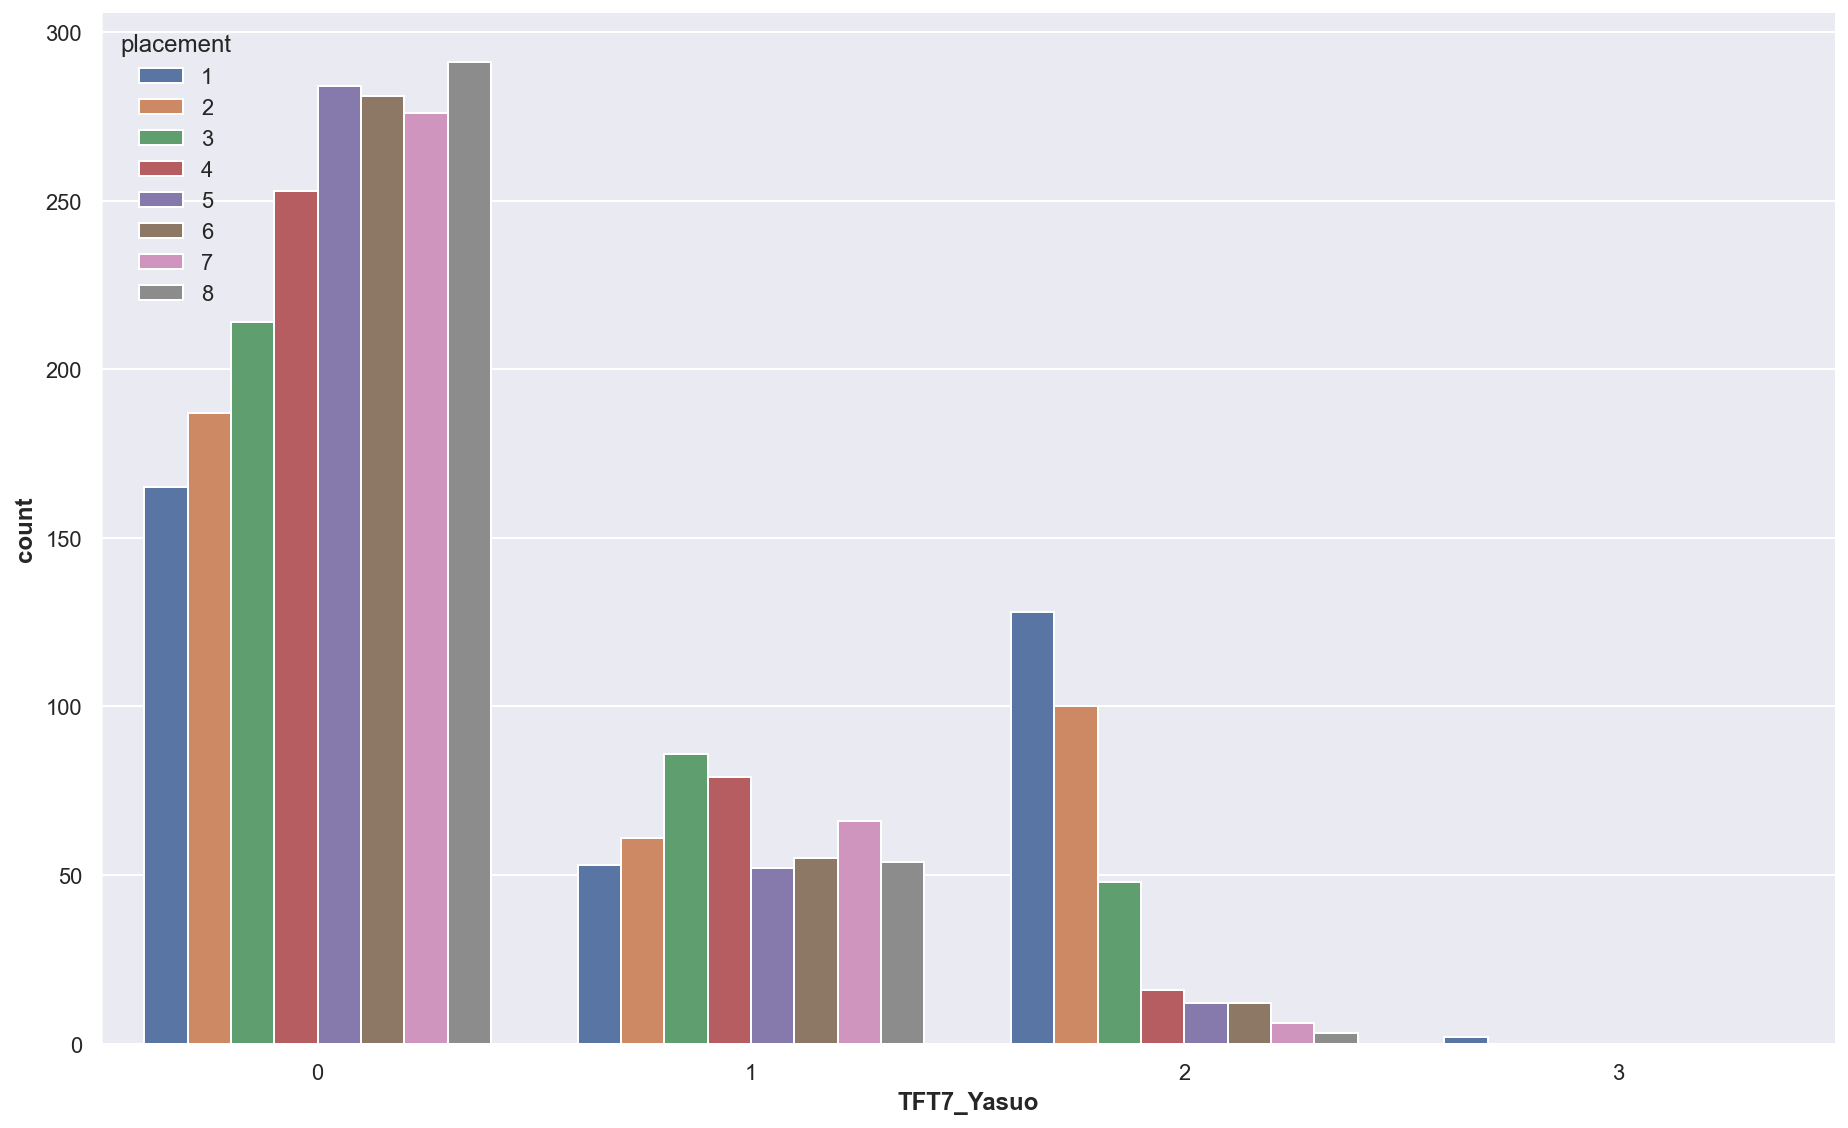

In [842]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Yasuo', hue=TARGETNAME)
sns.despine()

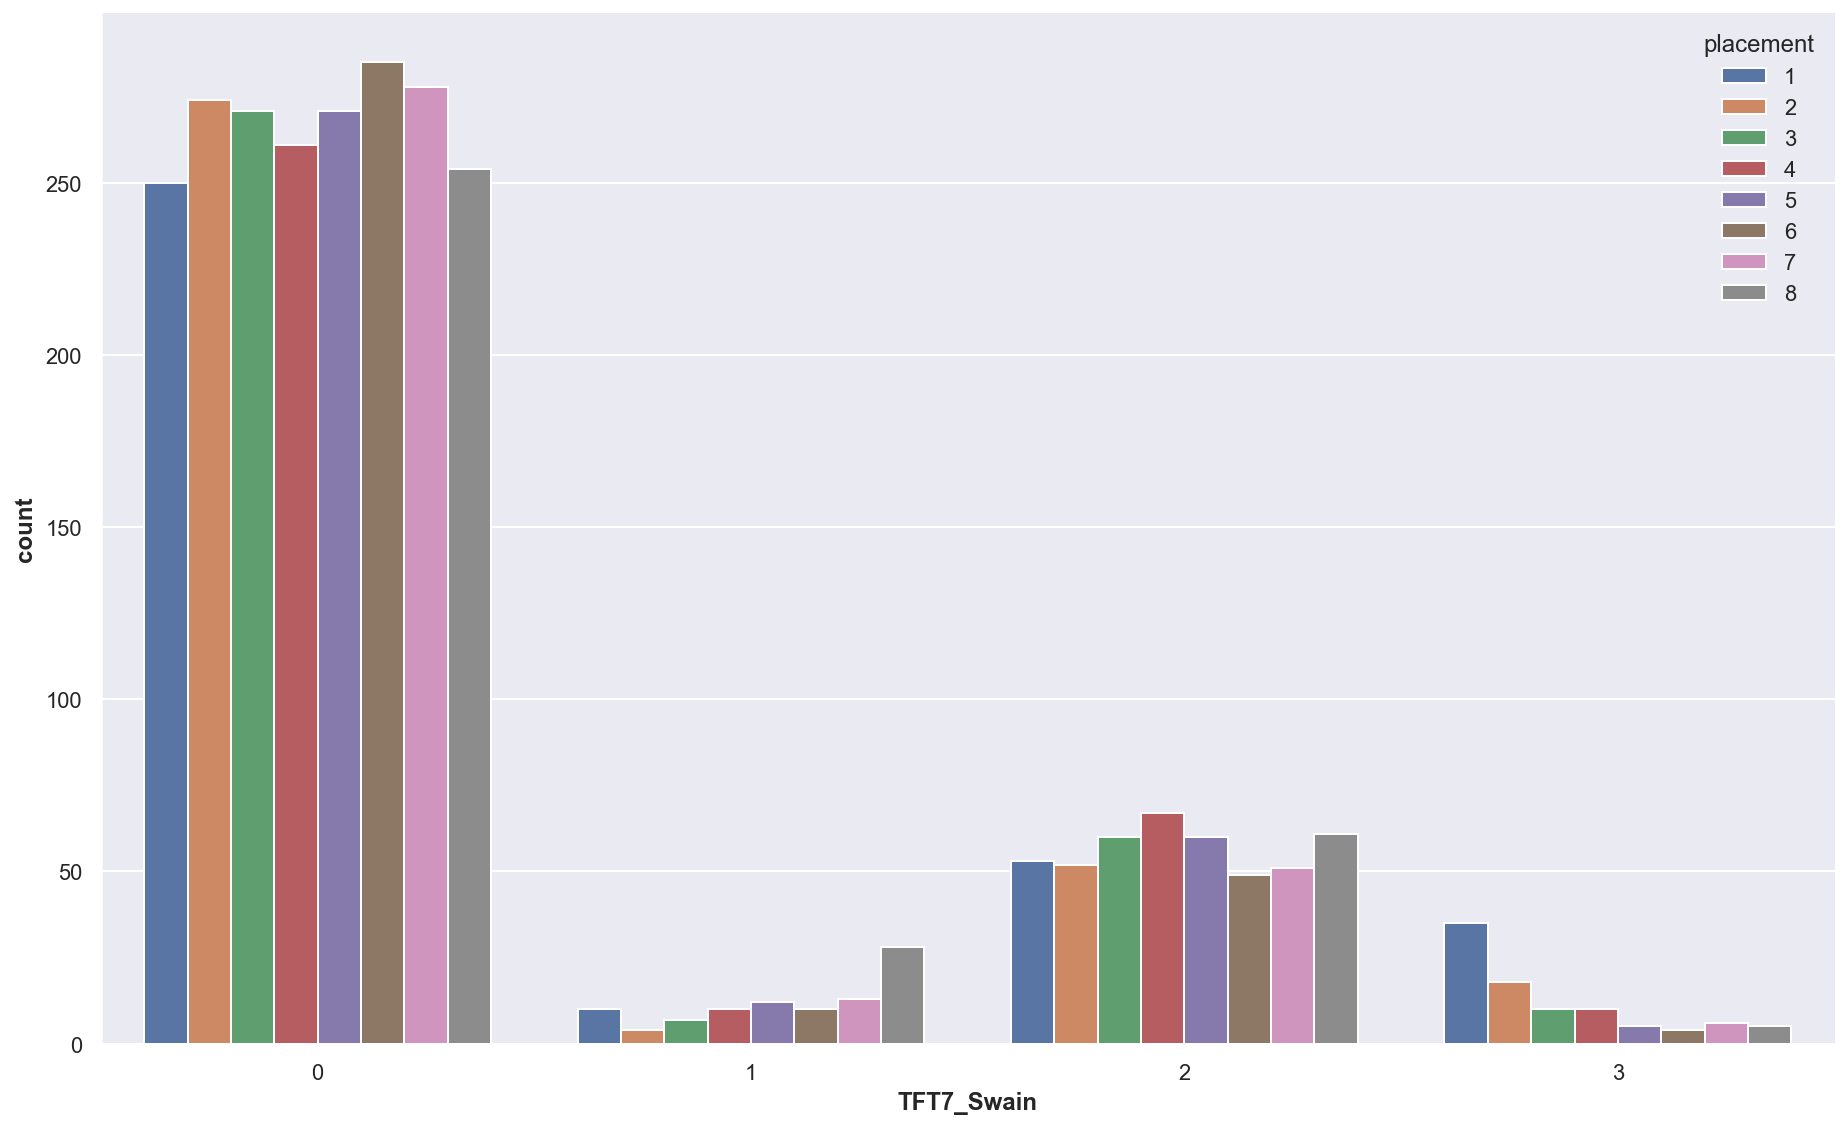

In [843]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Swain', hue=TARGETNAME)
sns.despine()

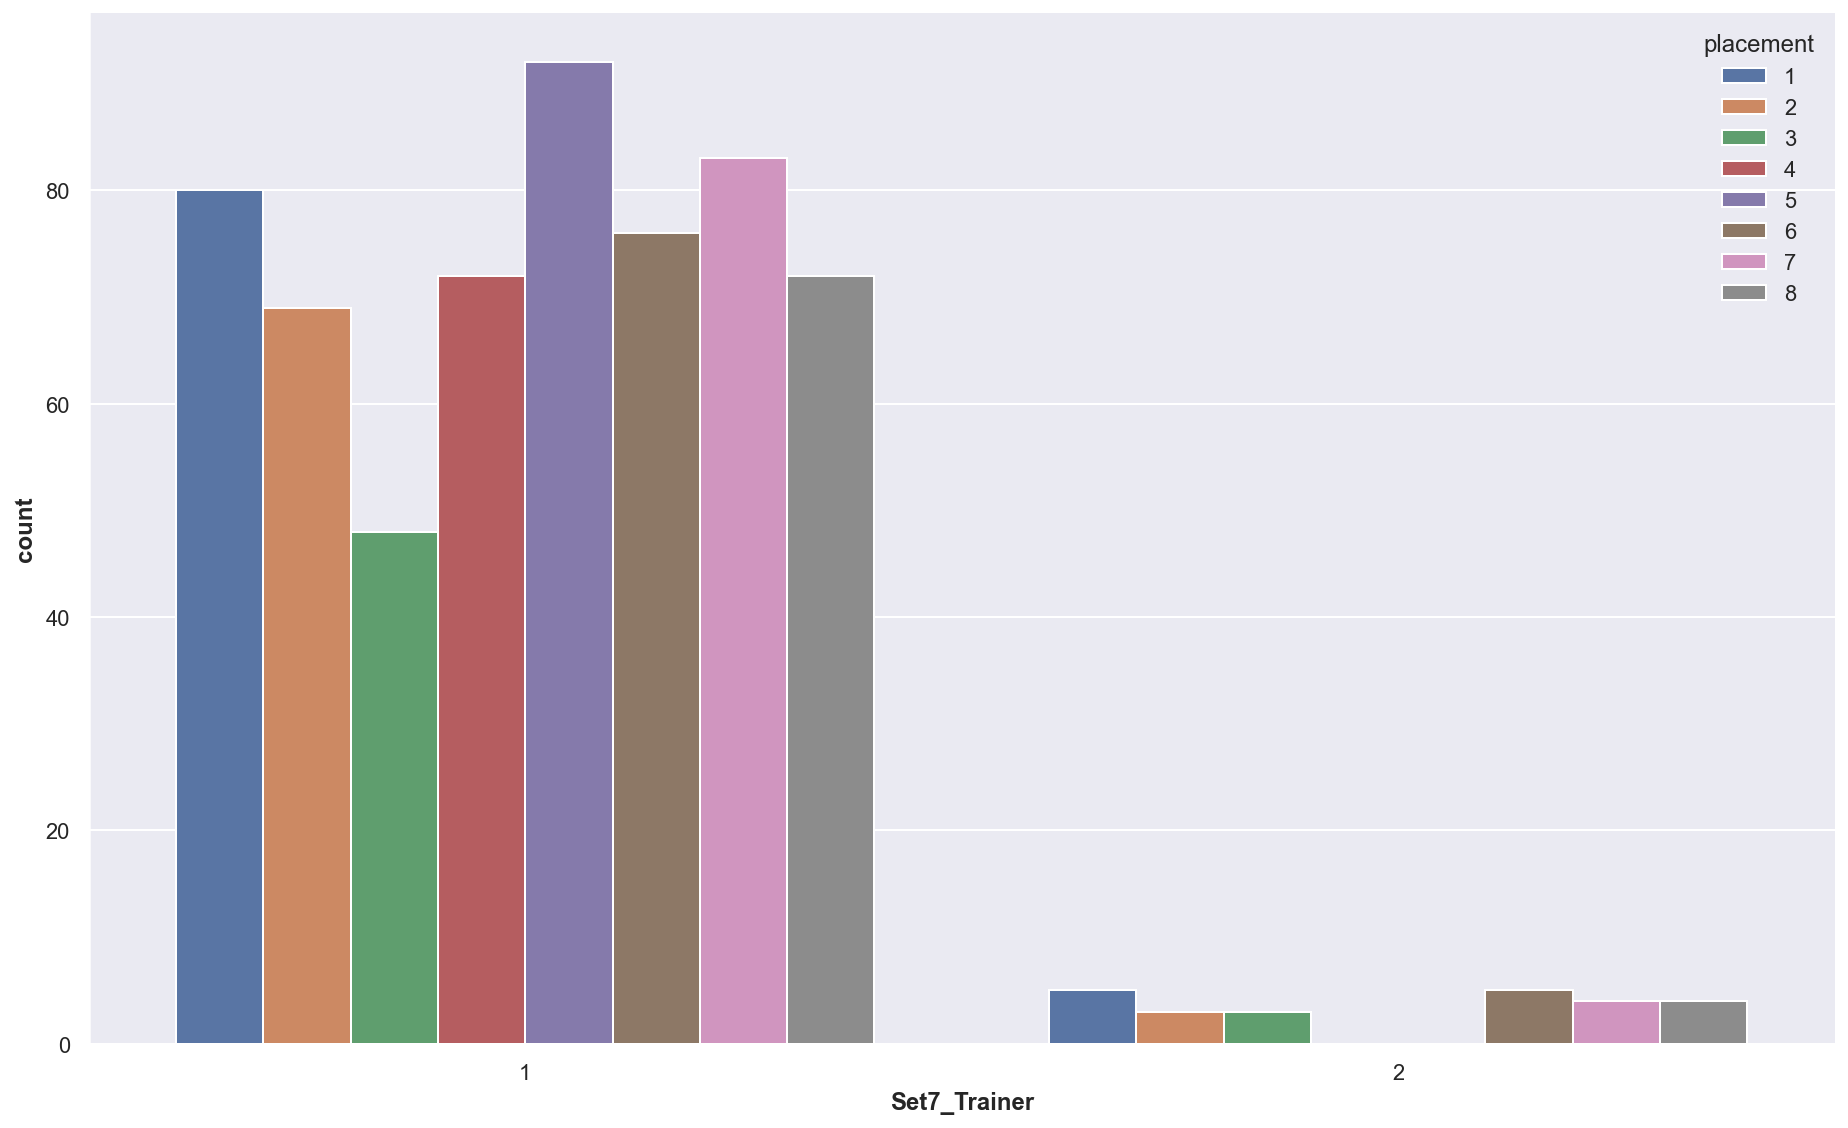

In [844]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Trainer']>0], x='Set7_Trainer', hue=TARGETNAME)
sns.despine()

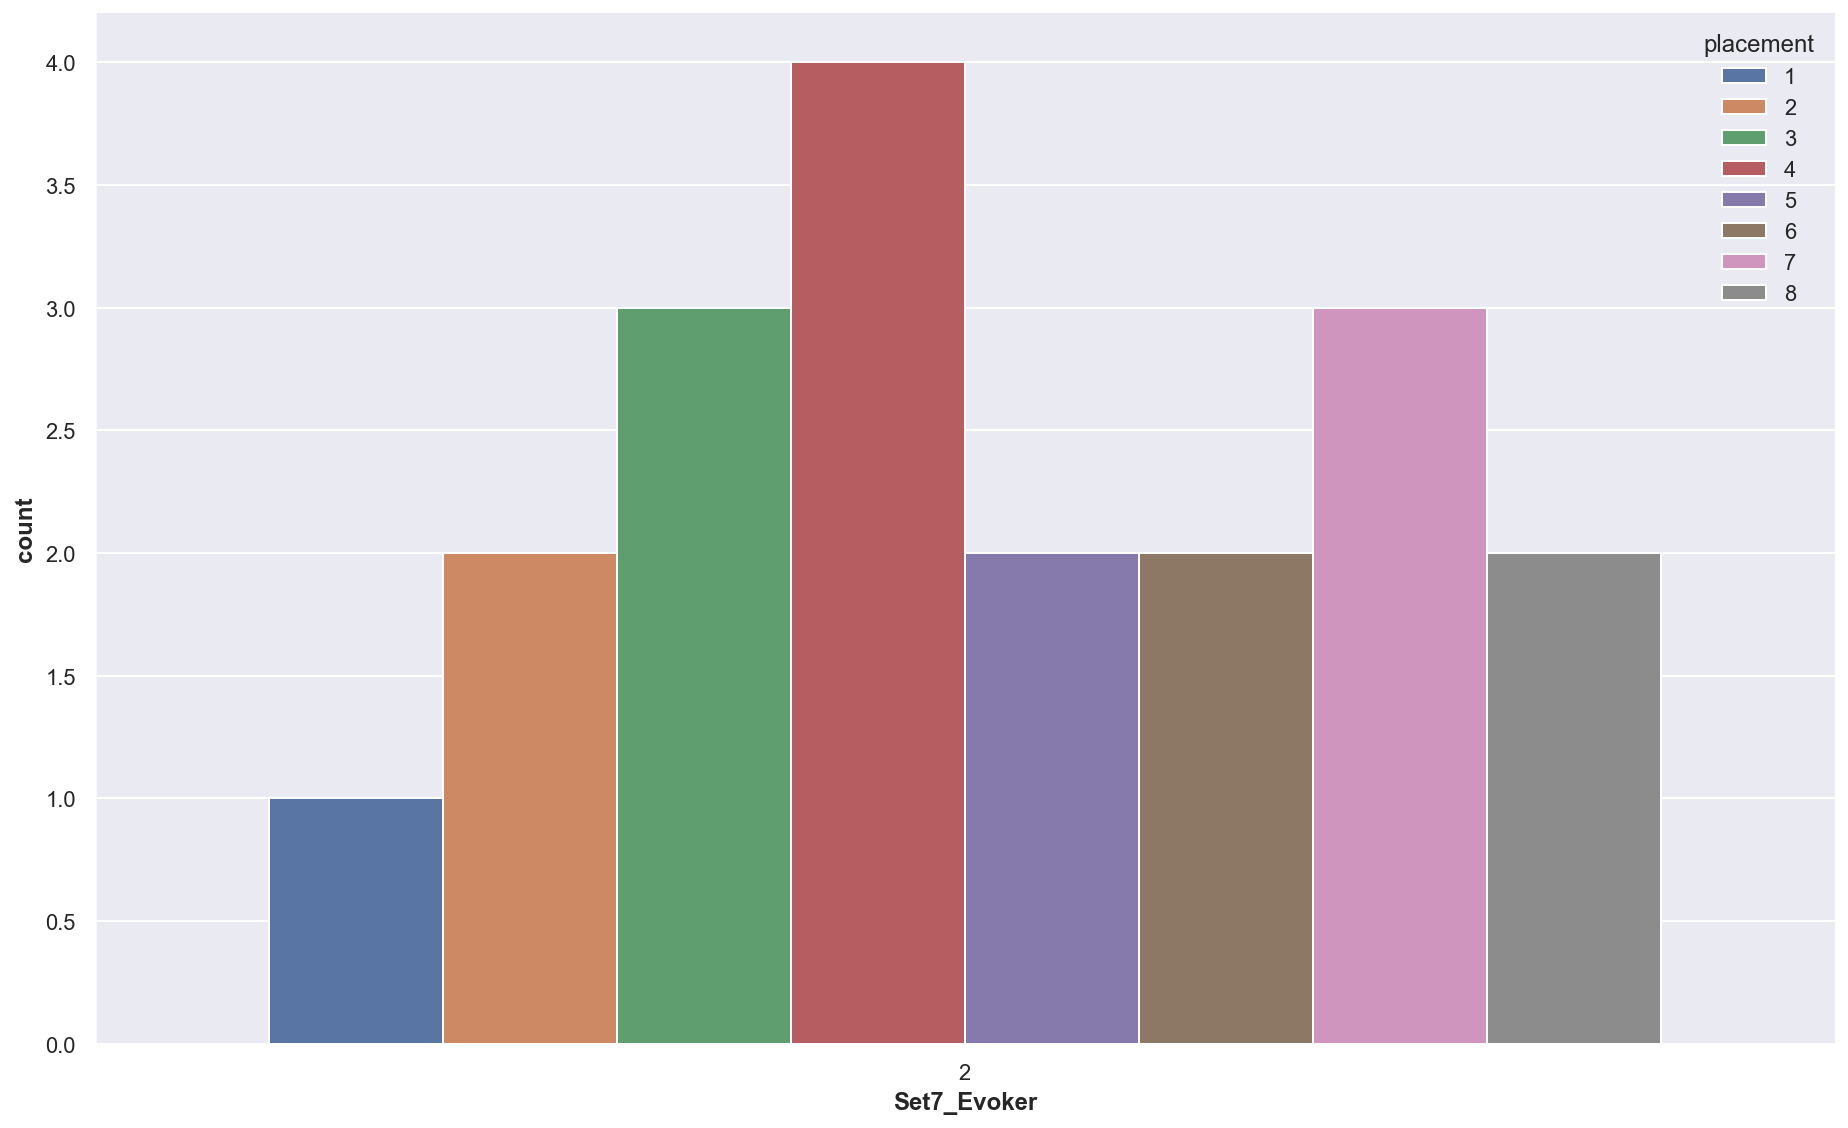

In [845]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Evoker']>1], x='Set7_Evoker', hue=TARGETNAME)
sns.despine()

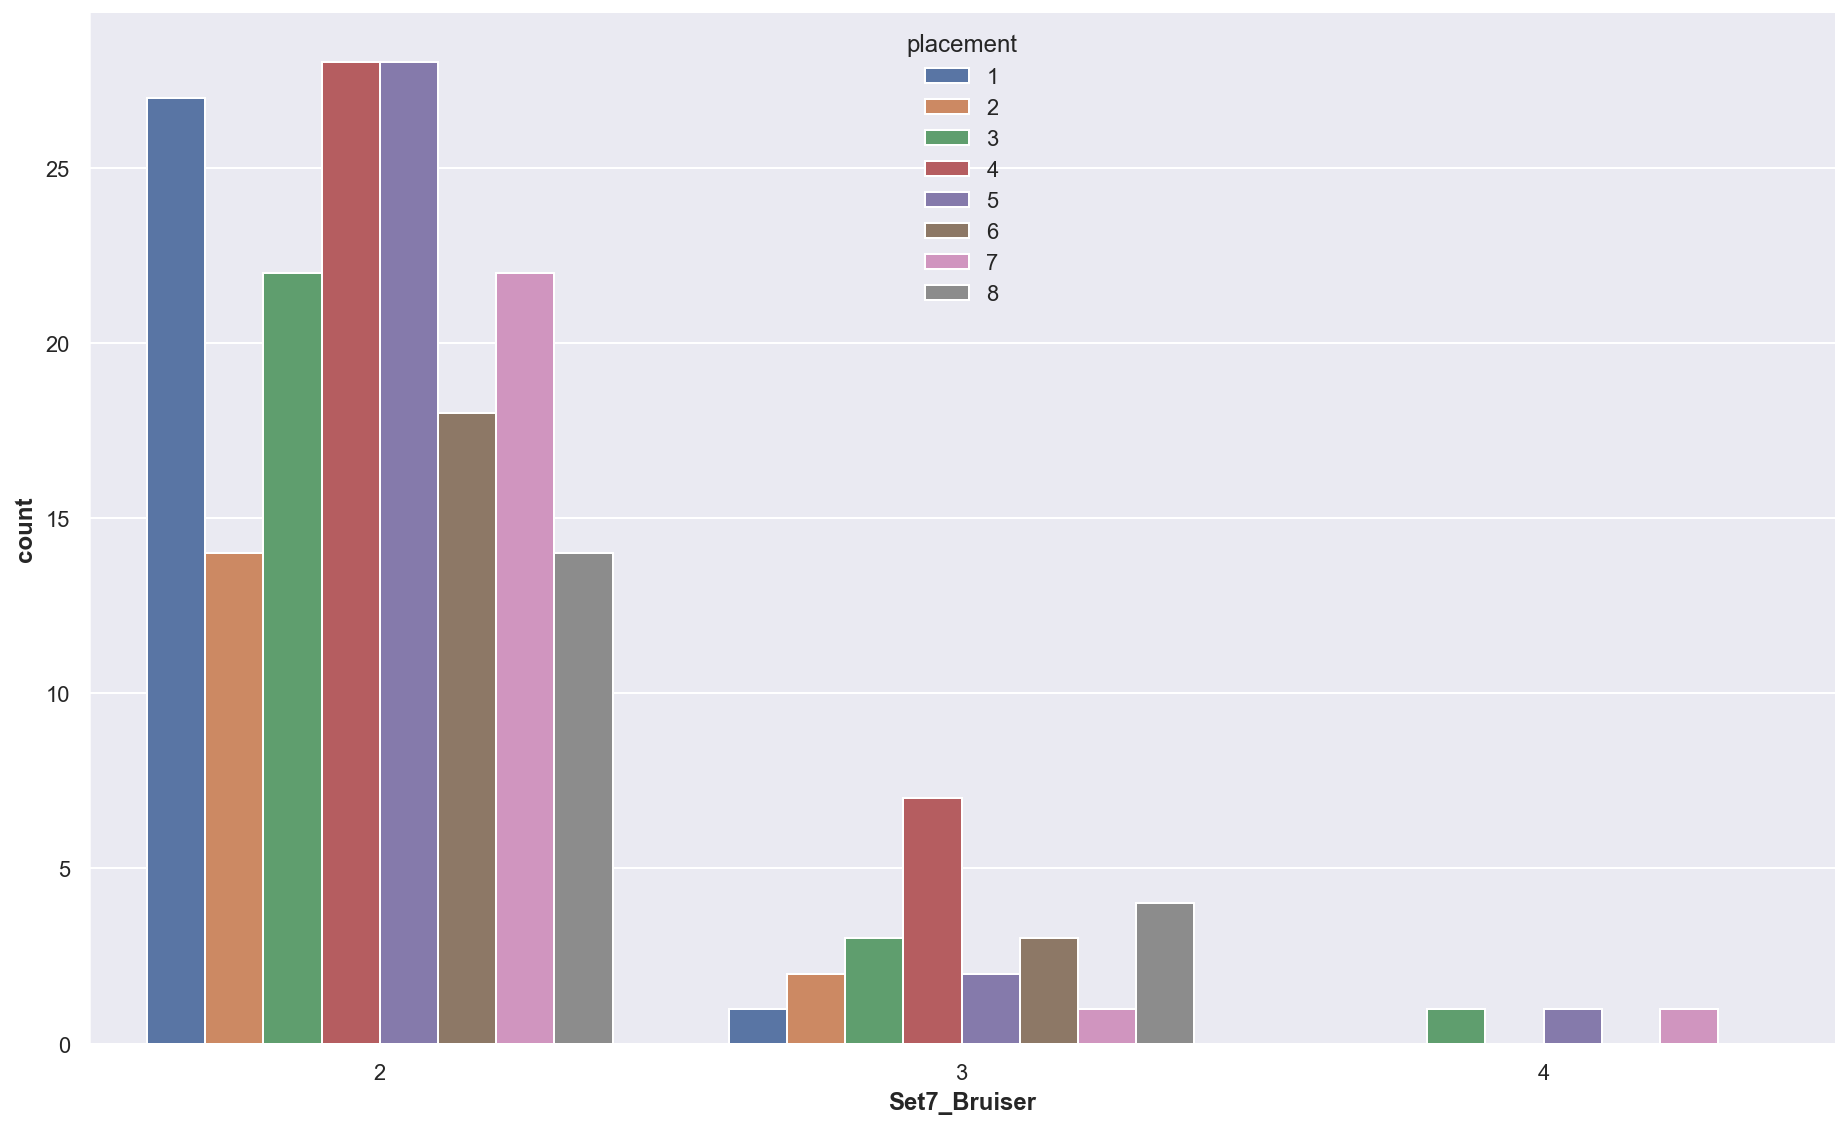

In [846]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Bruiser']>1], x='Set7_Bruiser', hue=TARGETNAME)
sns.despine()

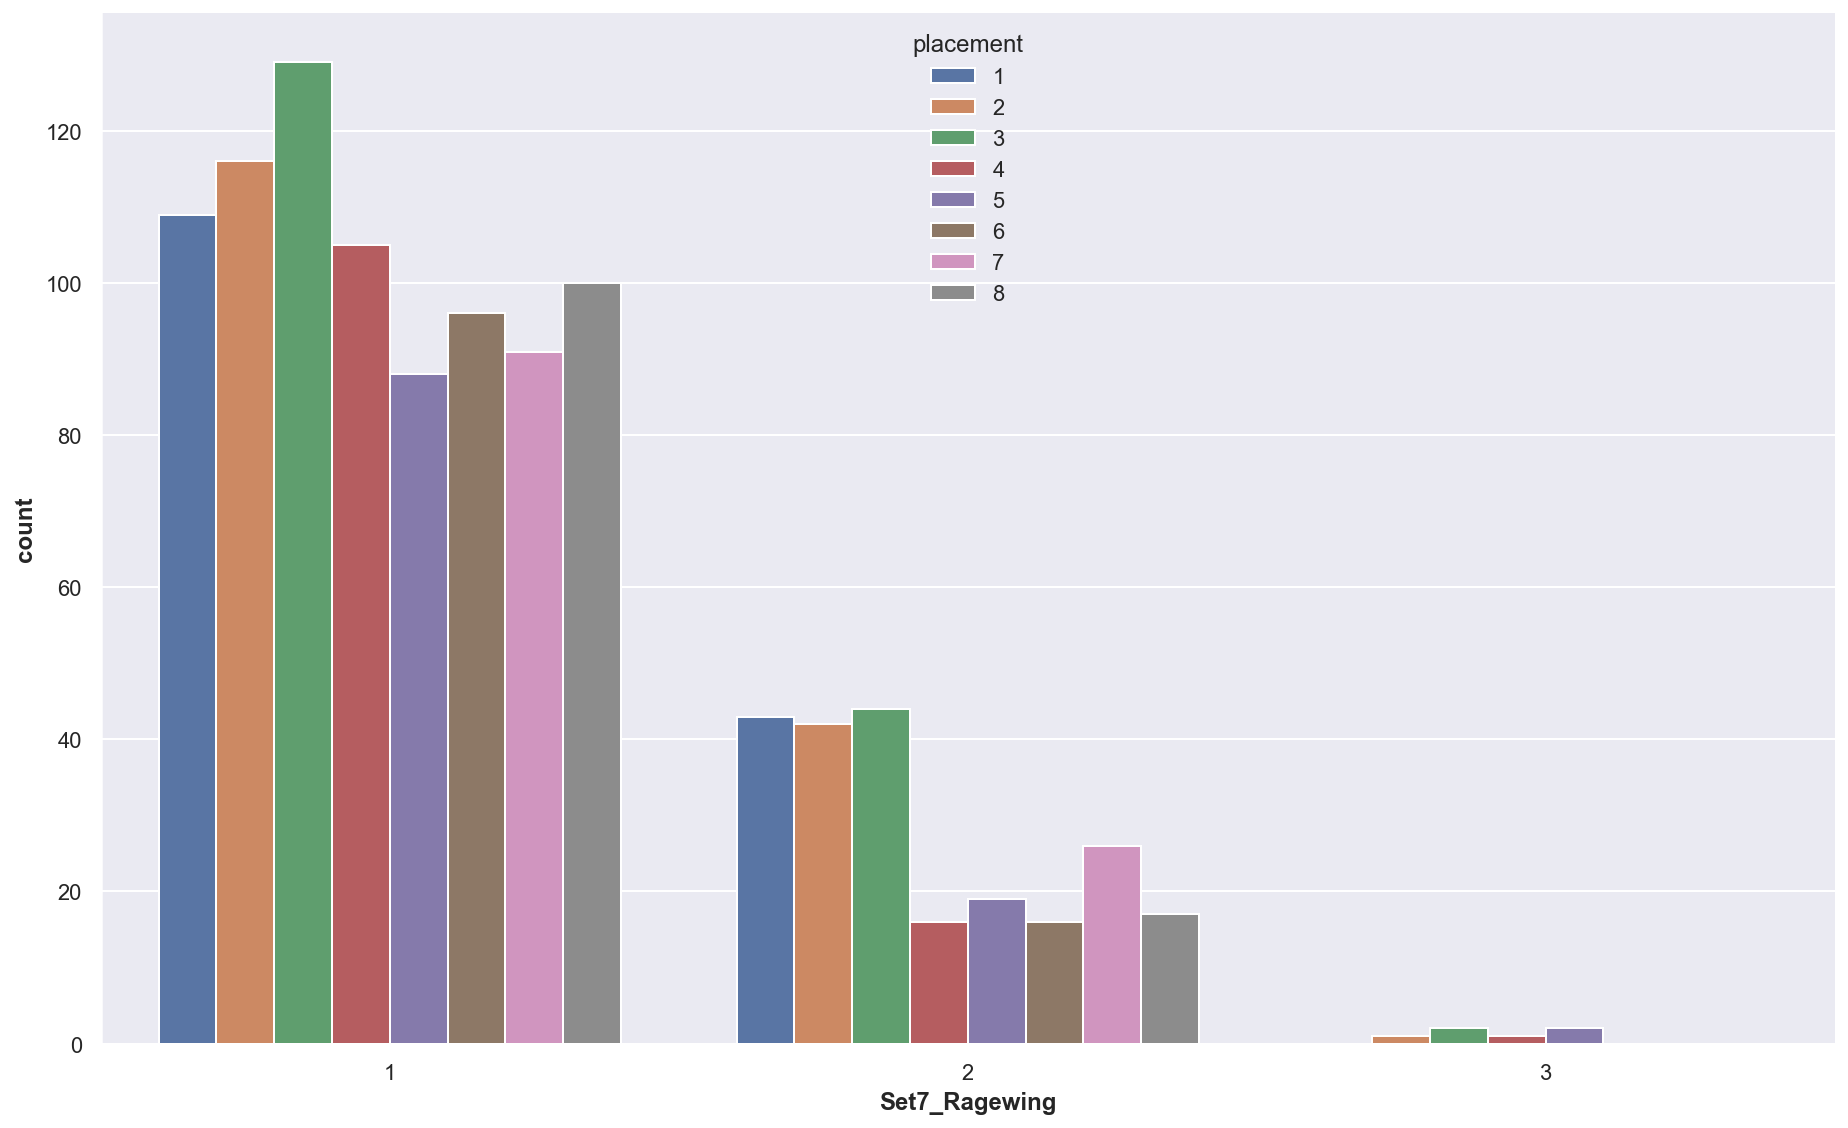

In [847]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Ragewing']>0], x='Set7_Ragewing', hue=TARGETNAME)
sns.despine()

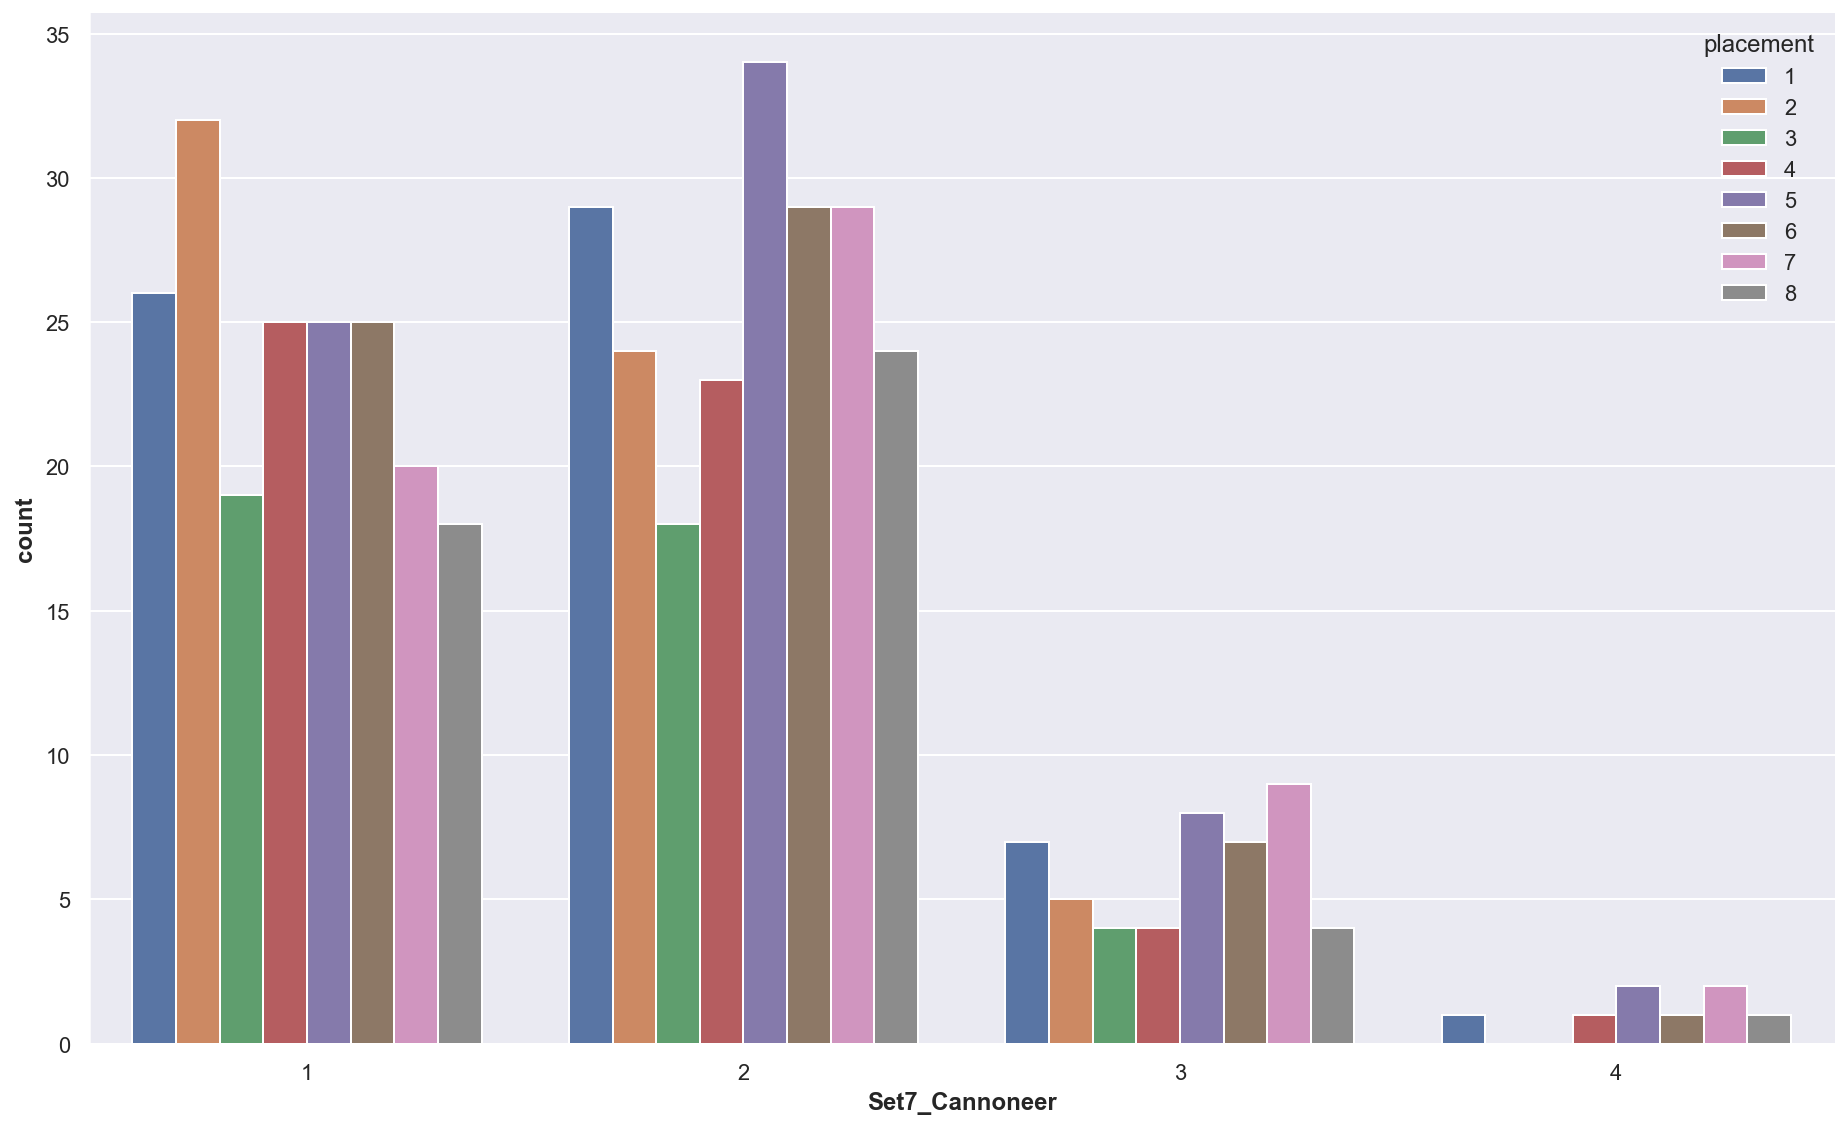

In [848]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Cannoneer']>0], x='Set7_Cannoneer', hue=TARGETNAME)
sns.despine()

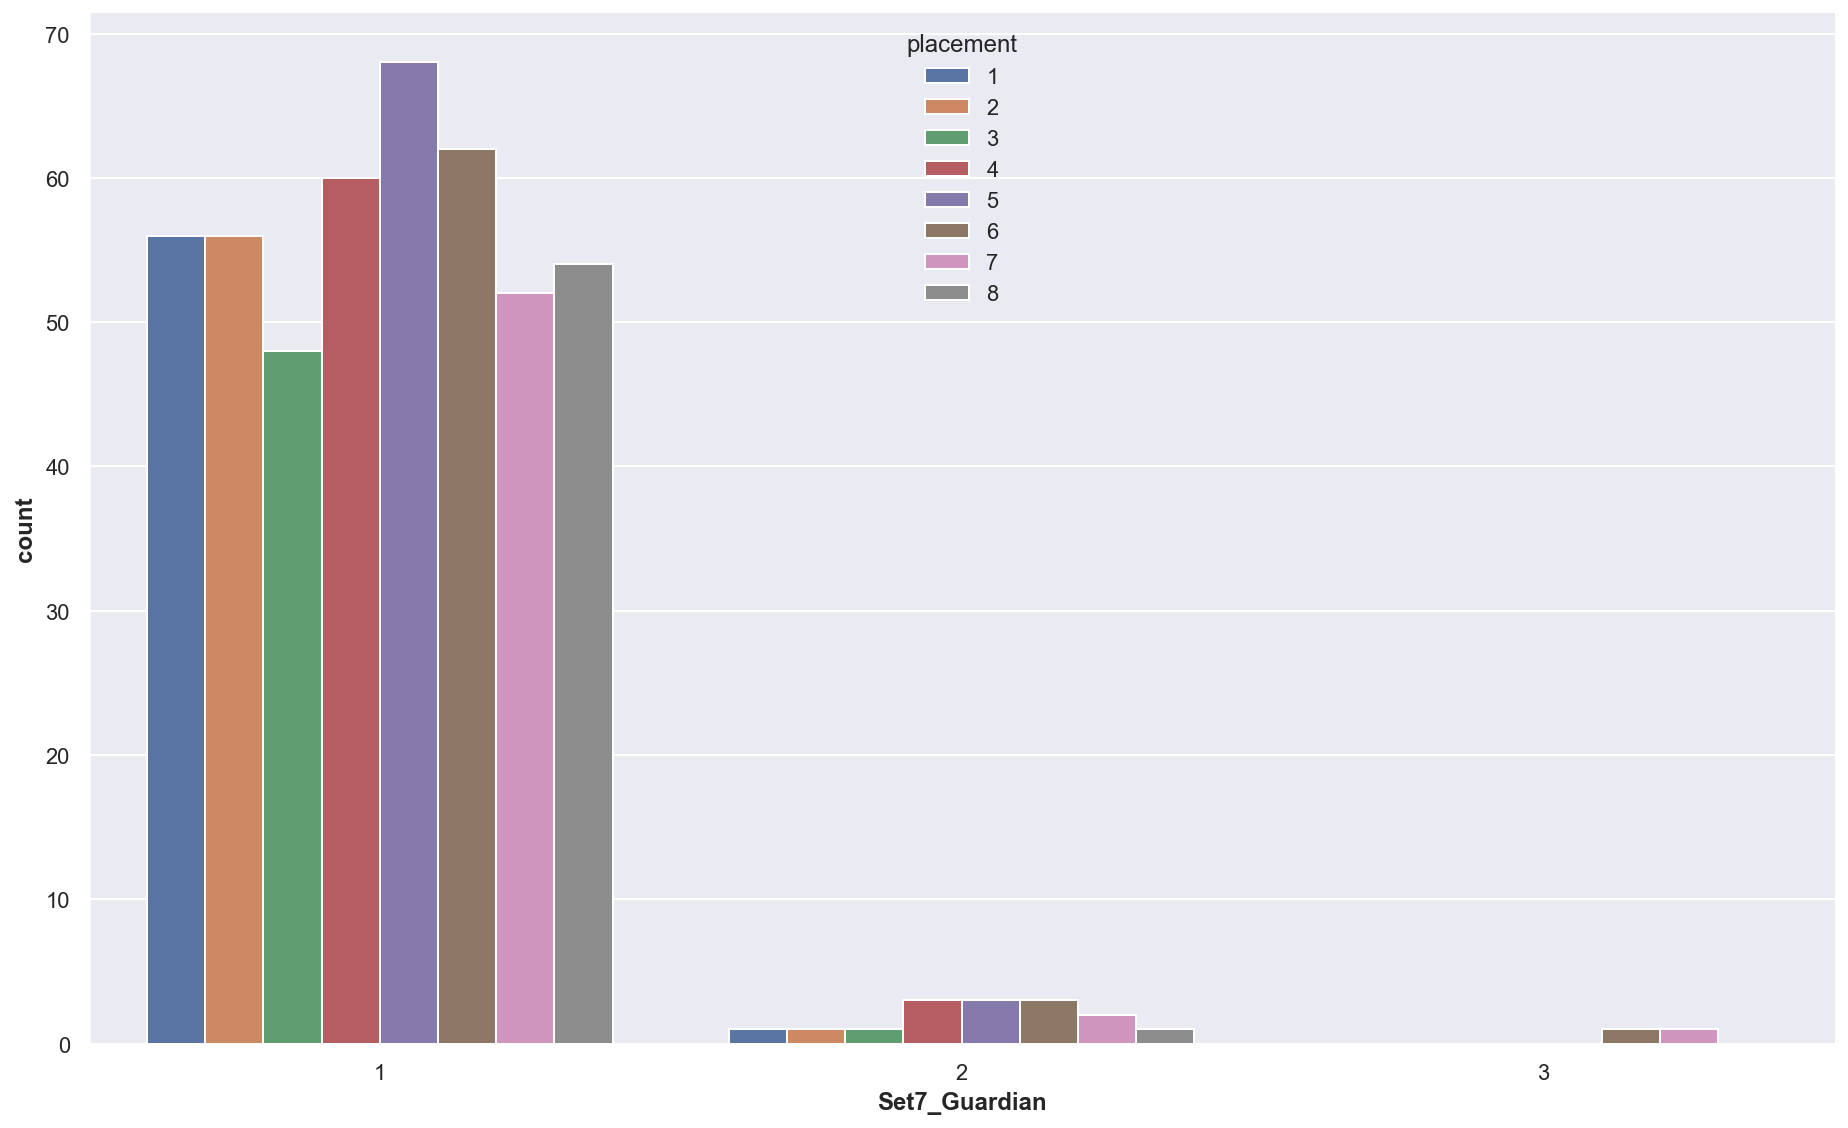

In [849]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Guardian']>0], x='Set7_Guardian', hue=TARGETNAME)
sns.despine()

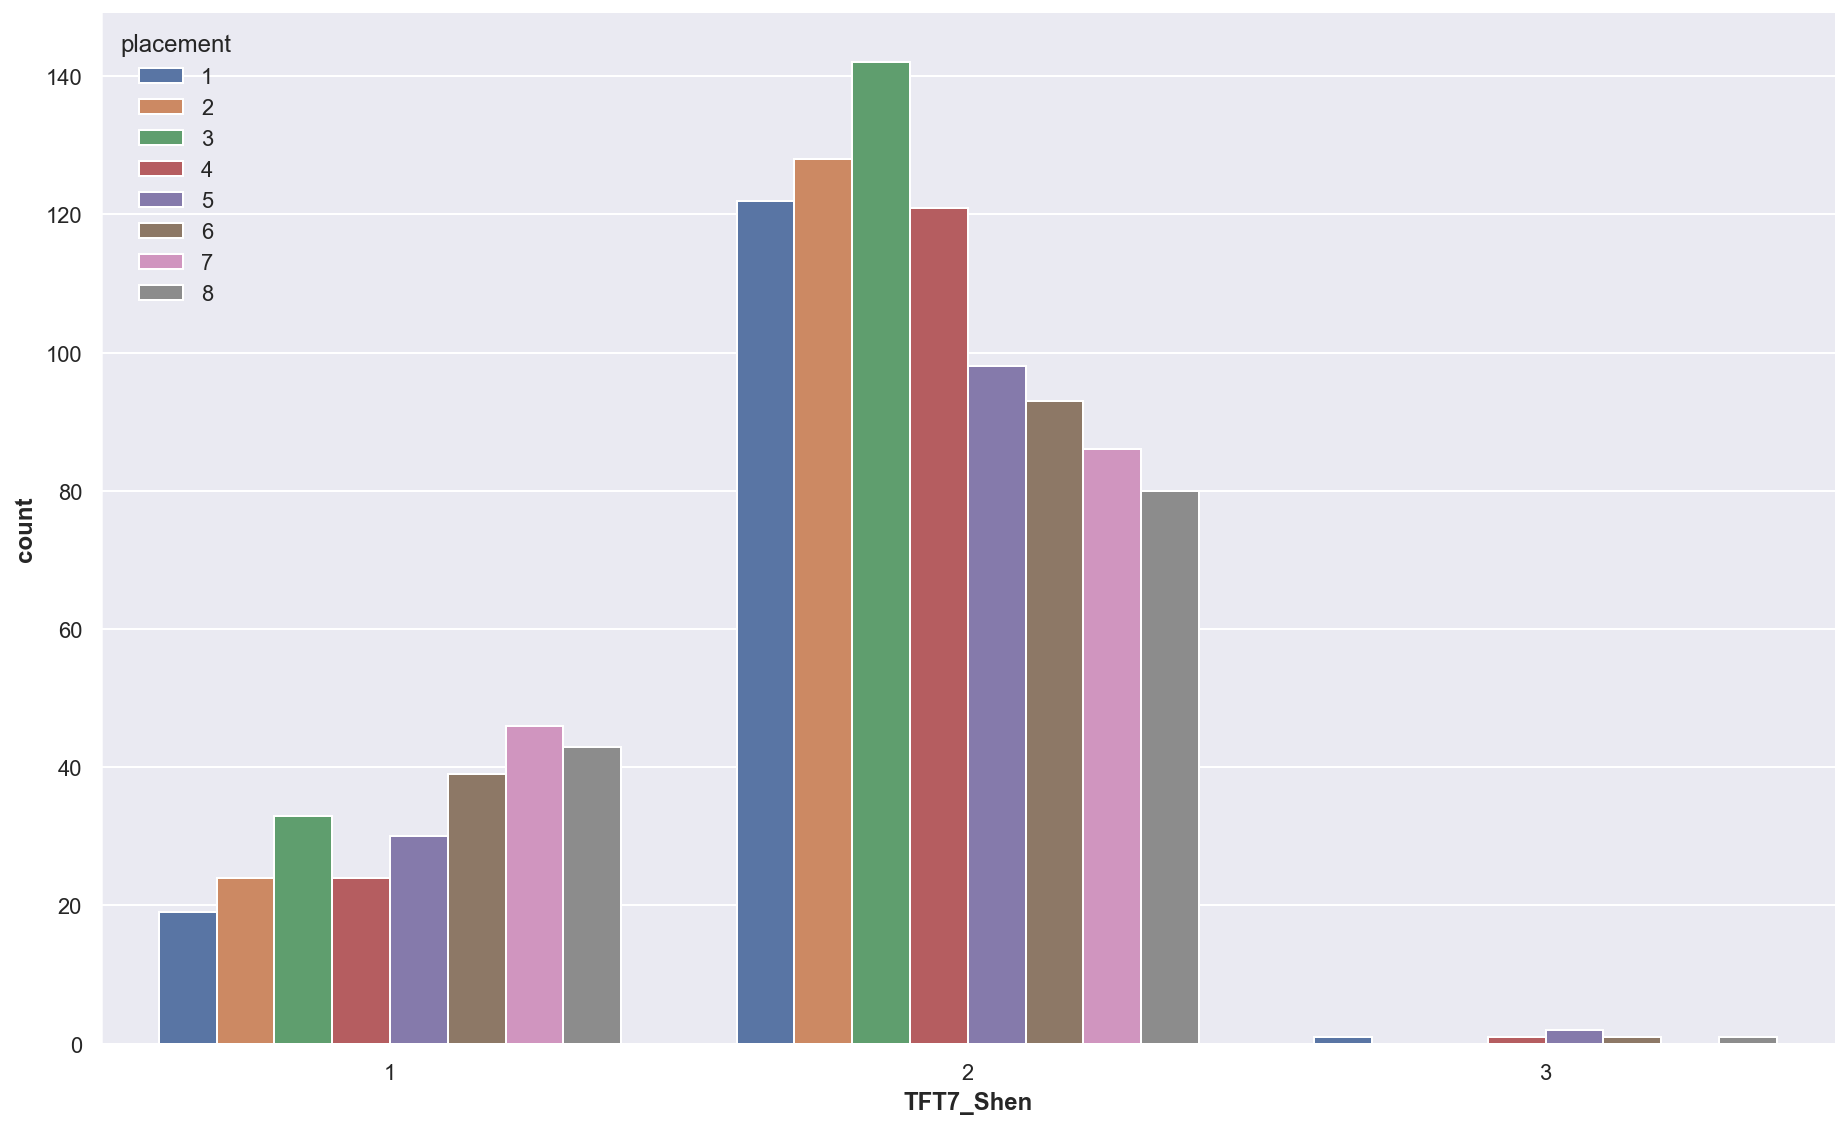

In [850]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Shen']>0], x='TFT7_Shen', hue=TARGETNAME)
sns.despine()

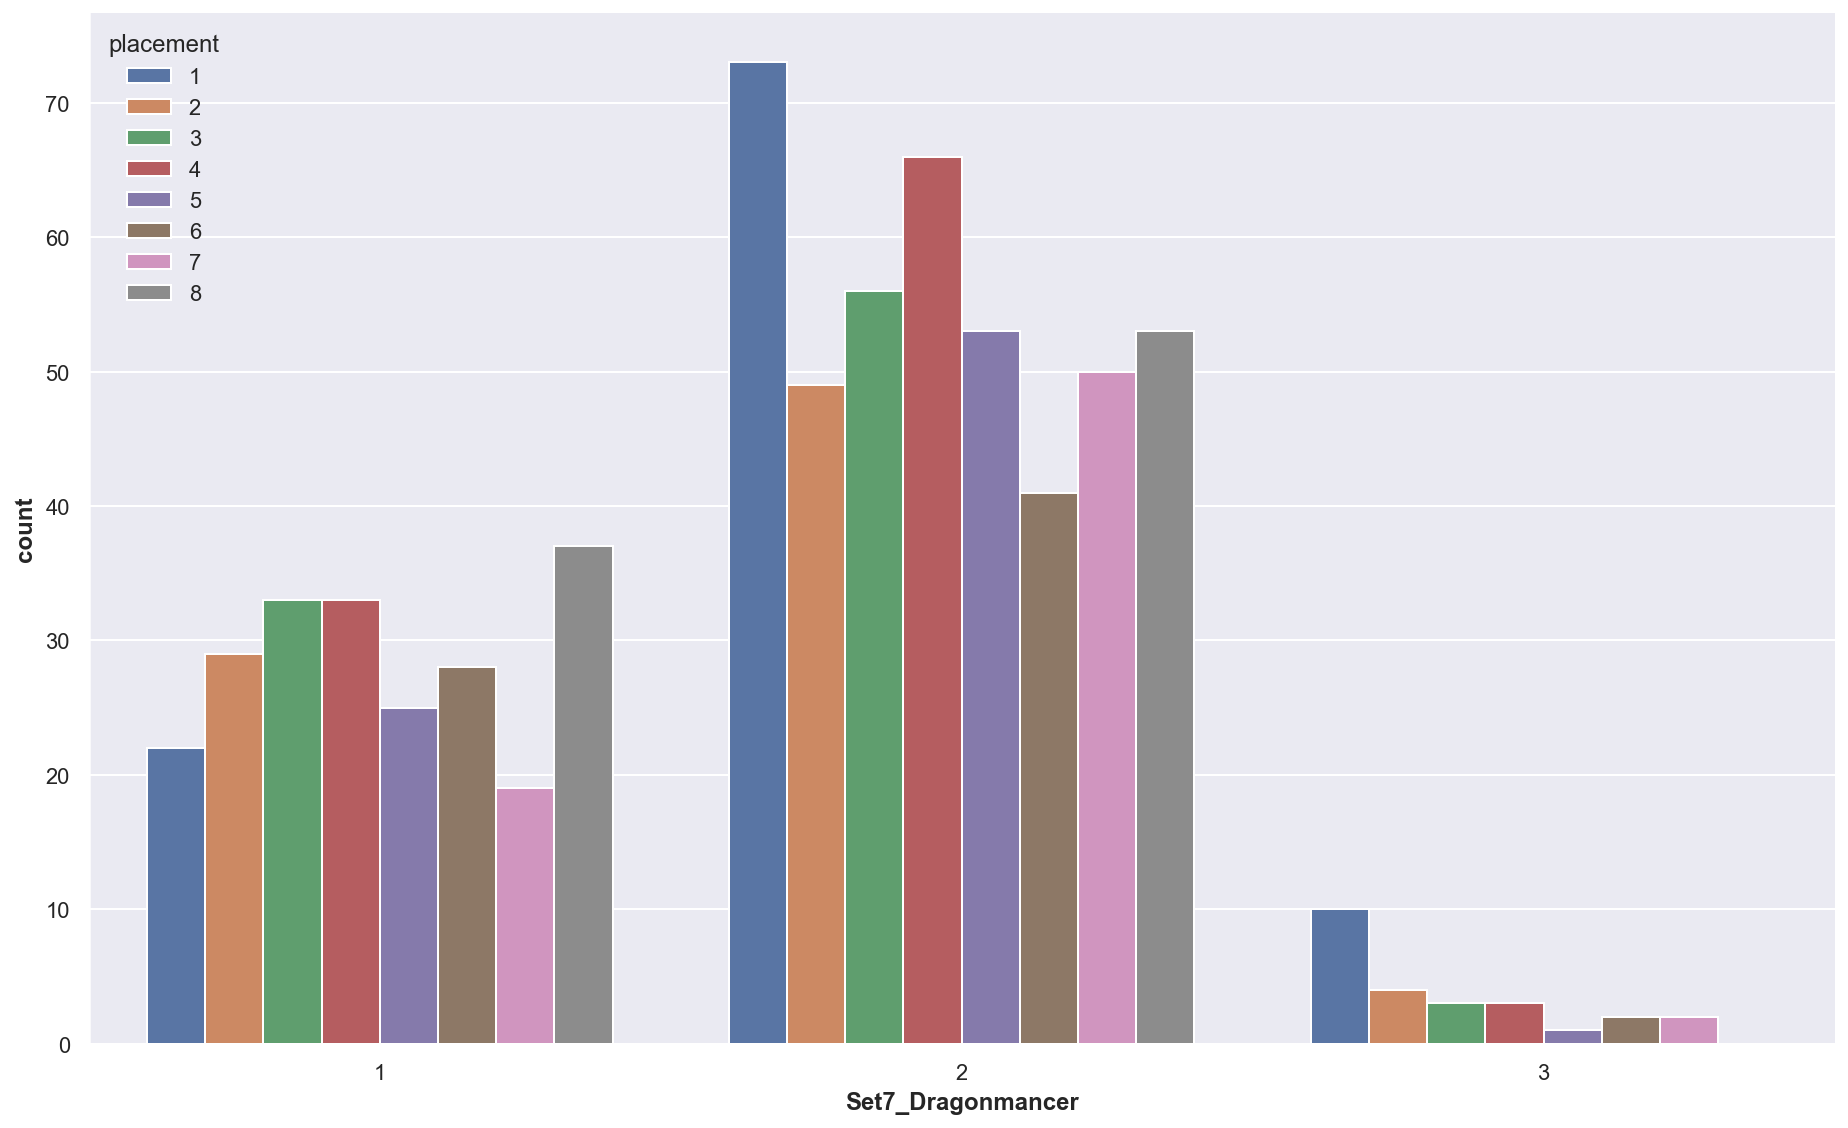

In [851]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Dragonmancer']>0], x='Set7_Dragonmancer', hue=TARGETNAME)
sns.despine()

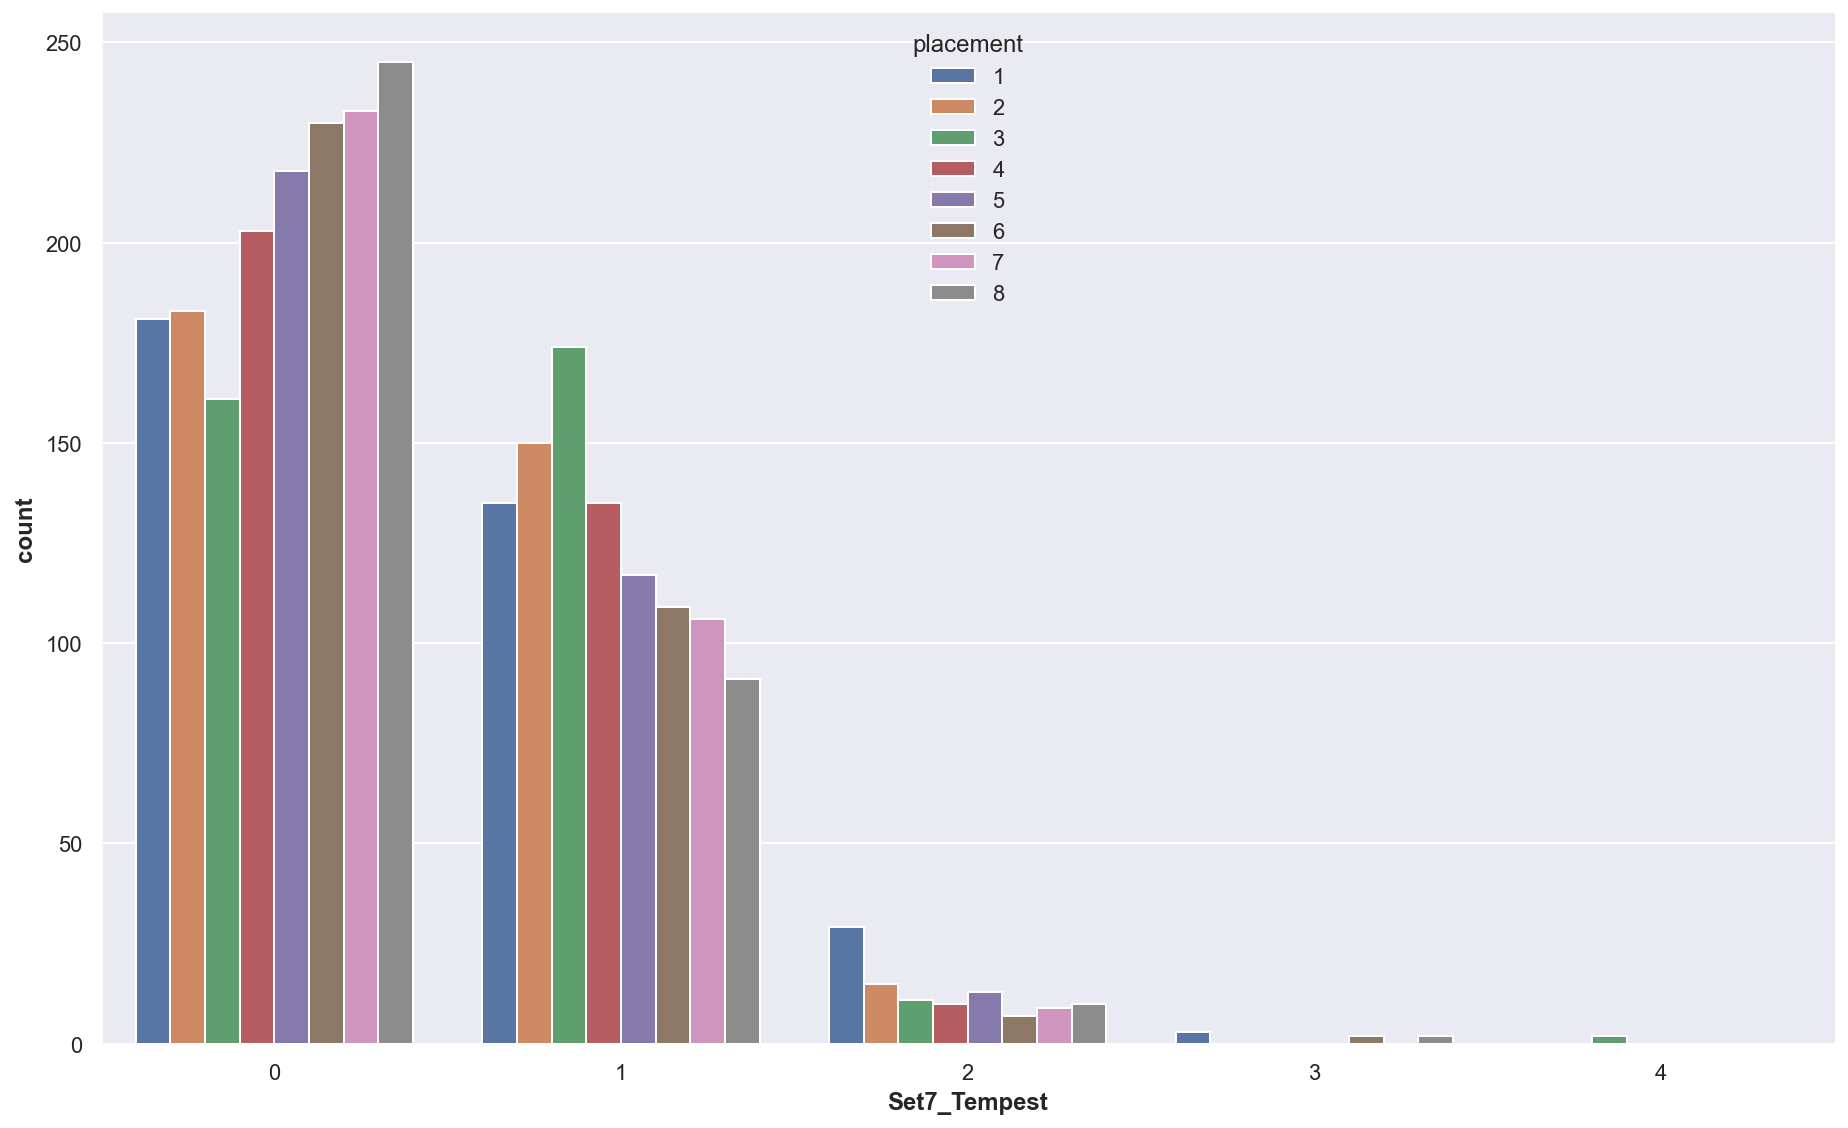

In [852]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Tempest', hue=TARGETNAME)
sns.despine()

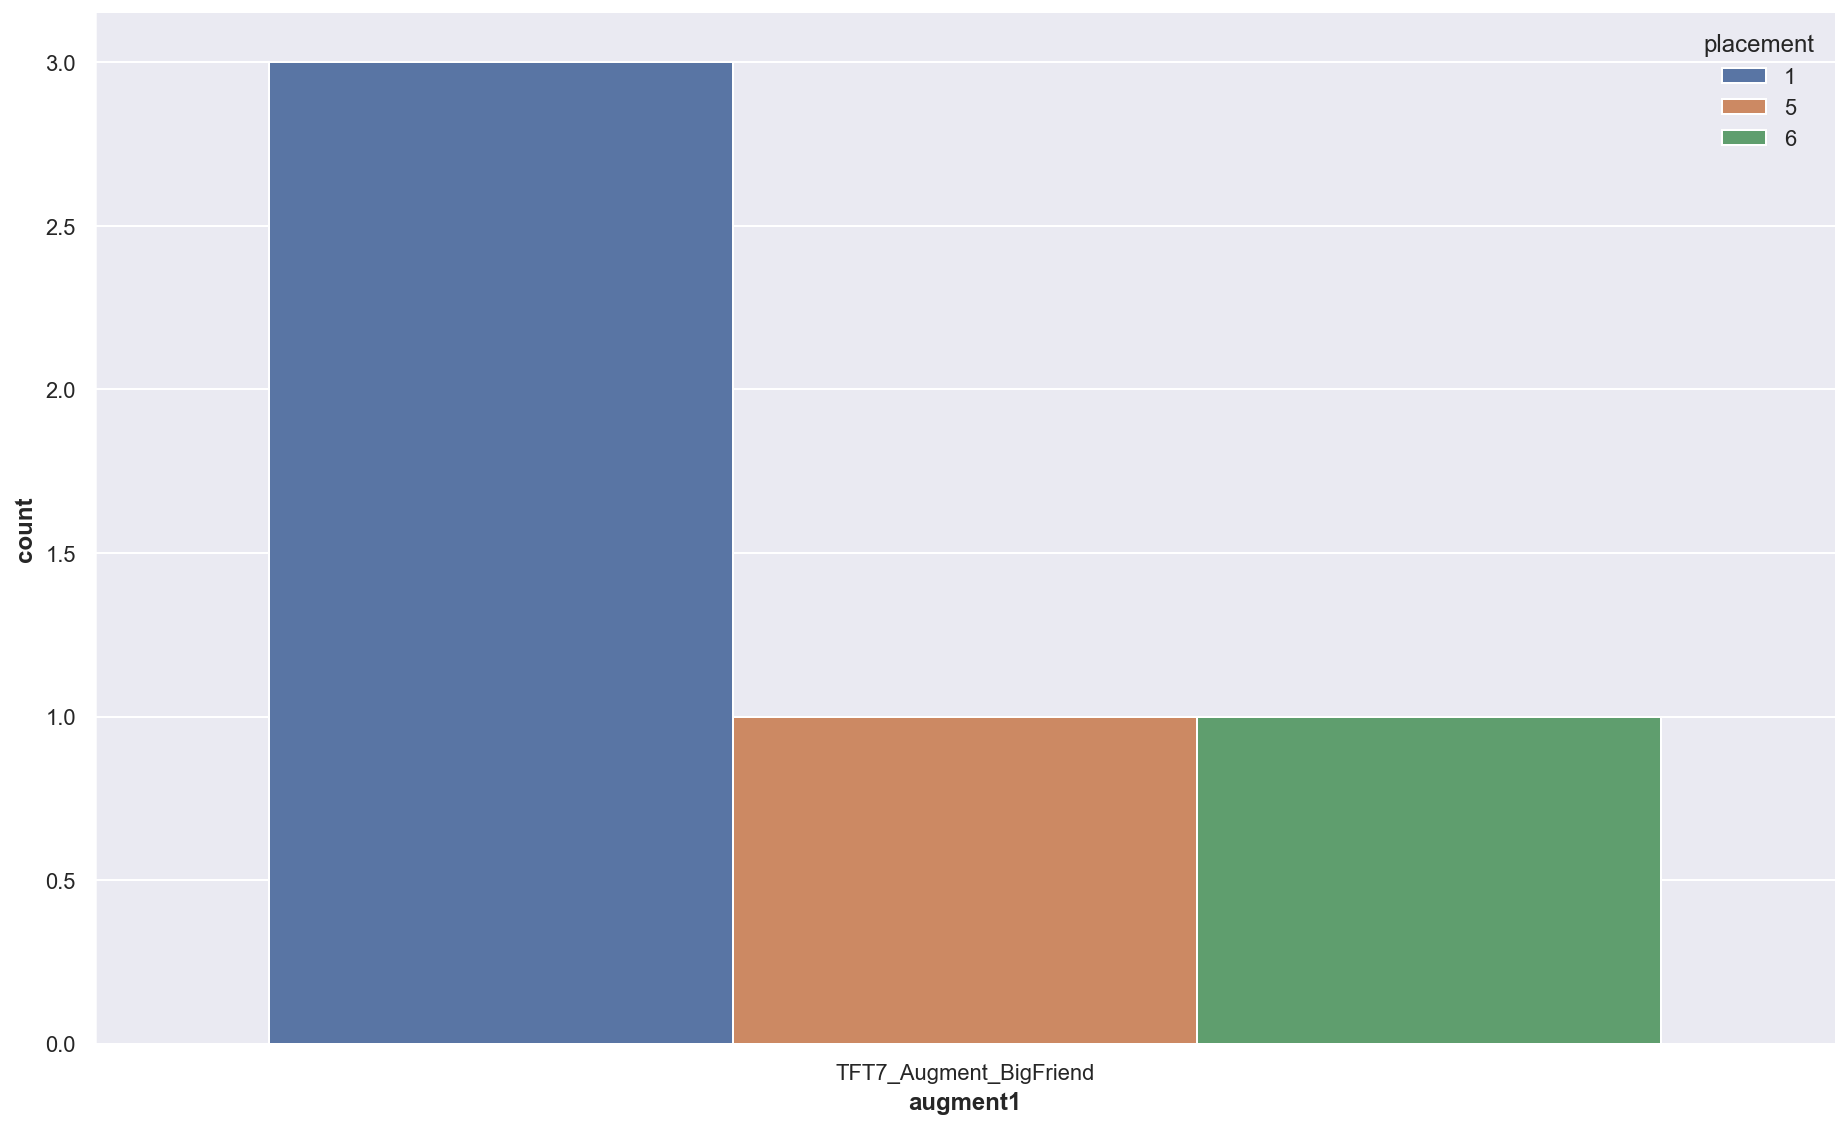

In [853]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['augment1']=='TFT7_Augment_BigFriend'], x='augment1', hue=TARGETNAME)
sns.despine()

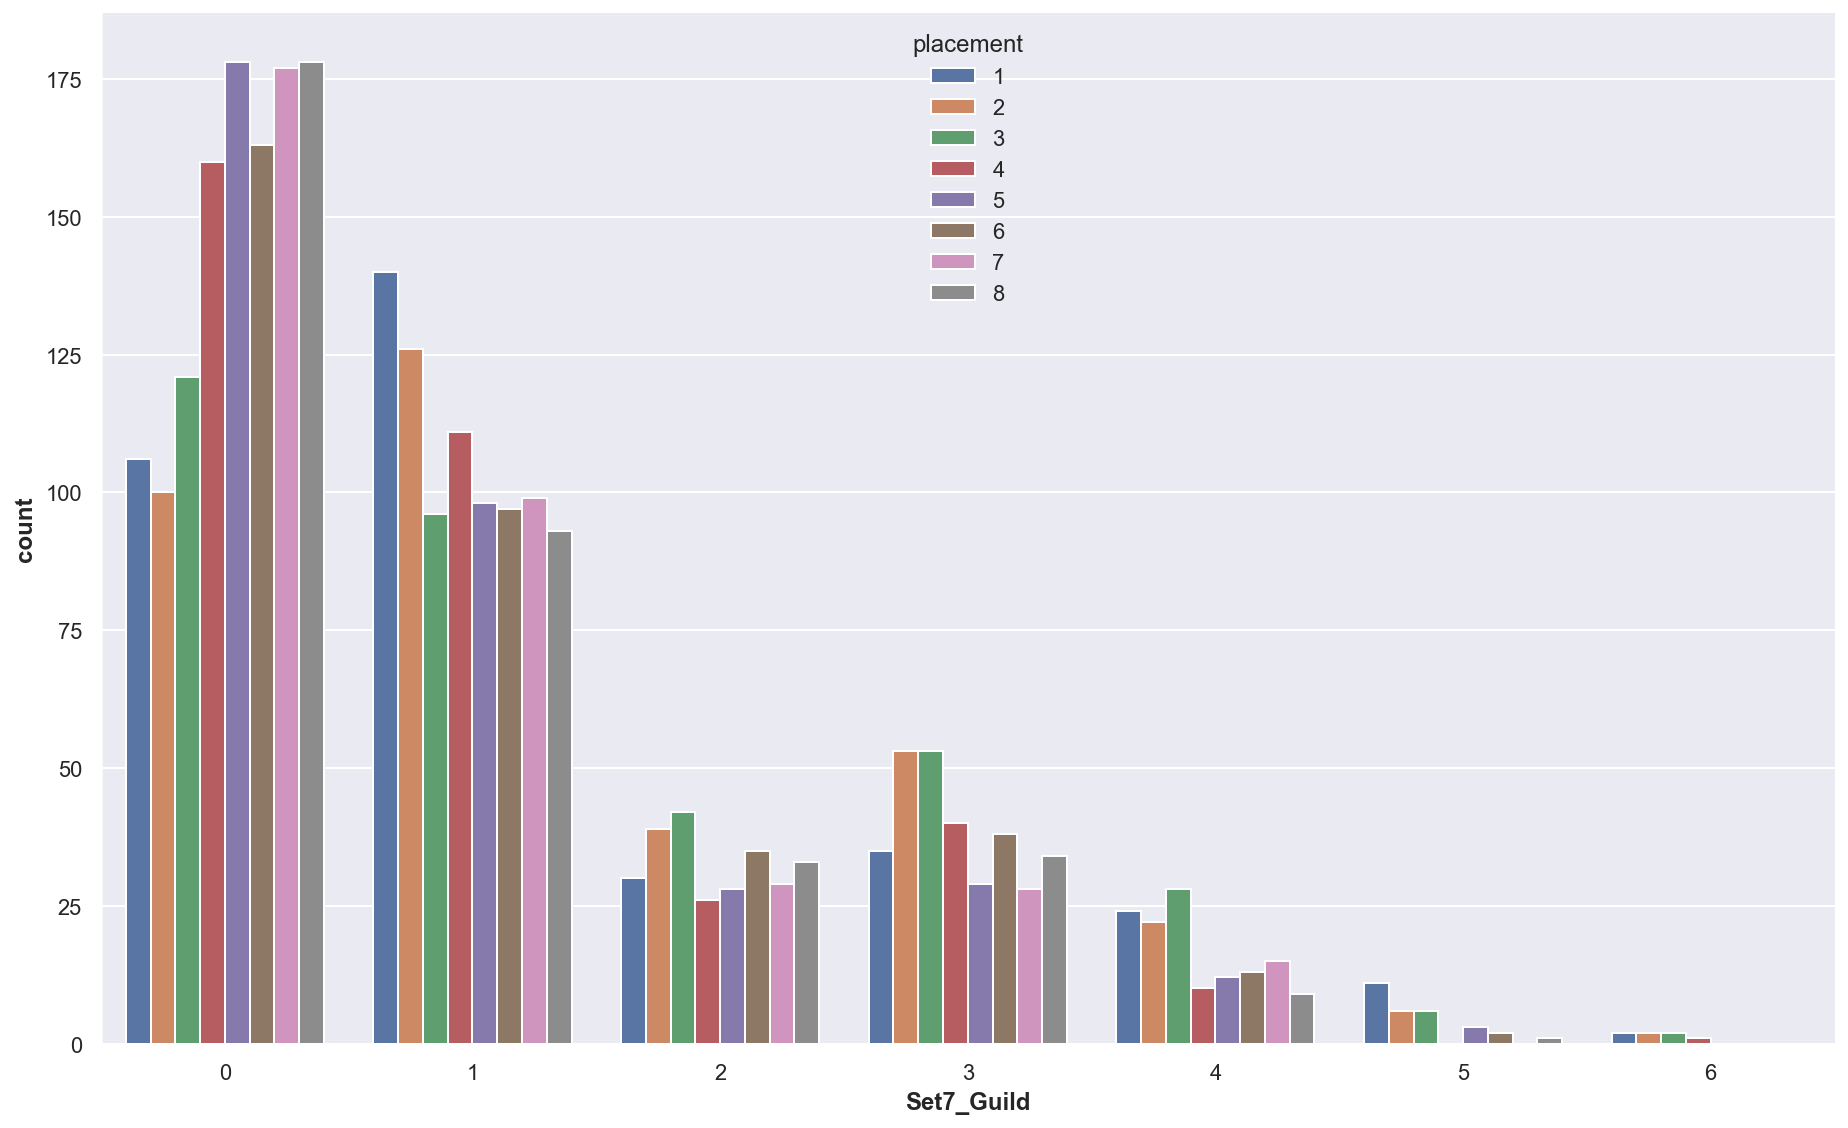

In [854]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Guild', hue=TARGETNAME)
sns.despine()

In [855]:
# X[categorical_cols] = X[categorical_cols].applymap(np.int64)

In [856]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [857]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='mae', tree_method='hist',
                    n_estimators=250, enable_categorical=True) #, use_label_encoder=False hist

In [858]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
augment_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
item_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
preproc = StandardScaler()

# Encode label. 0 = Show , 1 = No Show
y = le_target.fit_transform(y)

In [859]:
# augment_oe.fit(X[categorical_cols[:3]])

In [860]:
# item_oe.fit(X[categorical_cols[3:]])

In [861]:
# categorical_cols[3:]

In [862]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, categorical_cols),
            # ("augment", augment_oe, categorical_cols[:3]),
            # ("item", item_oe, categorical_cols[3:]),
        ],
        remainder=preproc,
        verbose_feature_names_out=False,
    ),
    xgb,
)

In [863]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('one_hot_time',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['augment0', 'augment1',
                                                   'augment2',
                                                   'TFT7_Twitch_item0',
                                                   'TFT7_Twitch_item1',
                                                   'TFT7_Nunu_item0',
                                                   'TFT7_Nunu_item1',
                                                   'TFT7_Nunu_item2',
                                                   'TFT7_Talon_item0',
                                                   'TFT7_Talon_item1',
                                                   'TFT7_Talon_item2',
                                                   '...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [864]:
y_pred = logistic_regression_pipeline.predict(X_test)

In [865]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [866]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [867]:
len(y_test)

418

In [868]:
y_pred.shape

(418,)

In [869]:
def plot_oof(y_true, y_predict):
    area = (30 * np.random.rand(len(y_predict)))**2 
    # Plot y_true vs. y_pred
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_predict, s=area, color='r', alpha=0.2)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

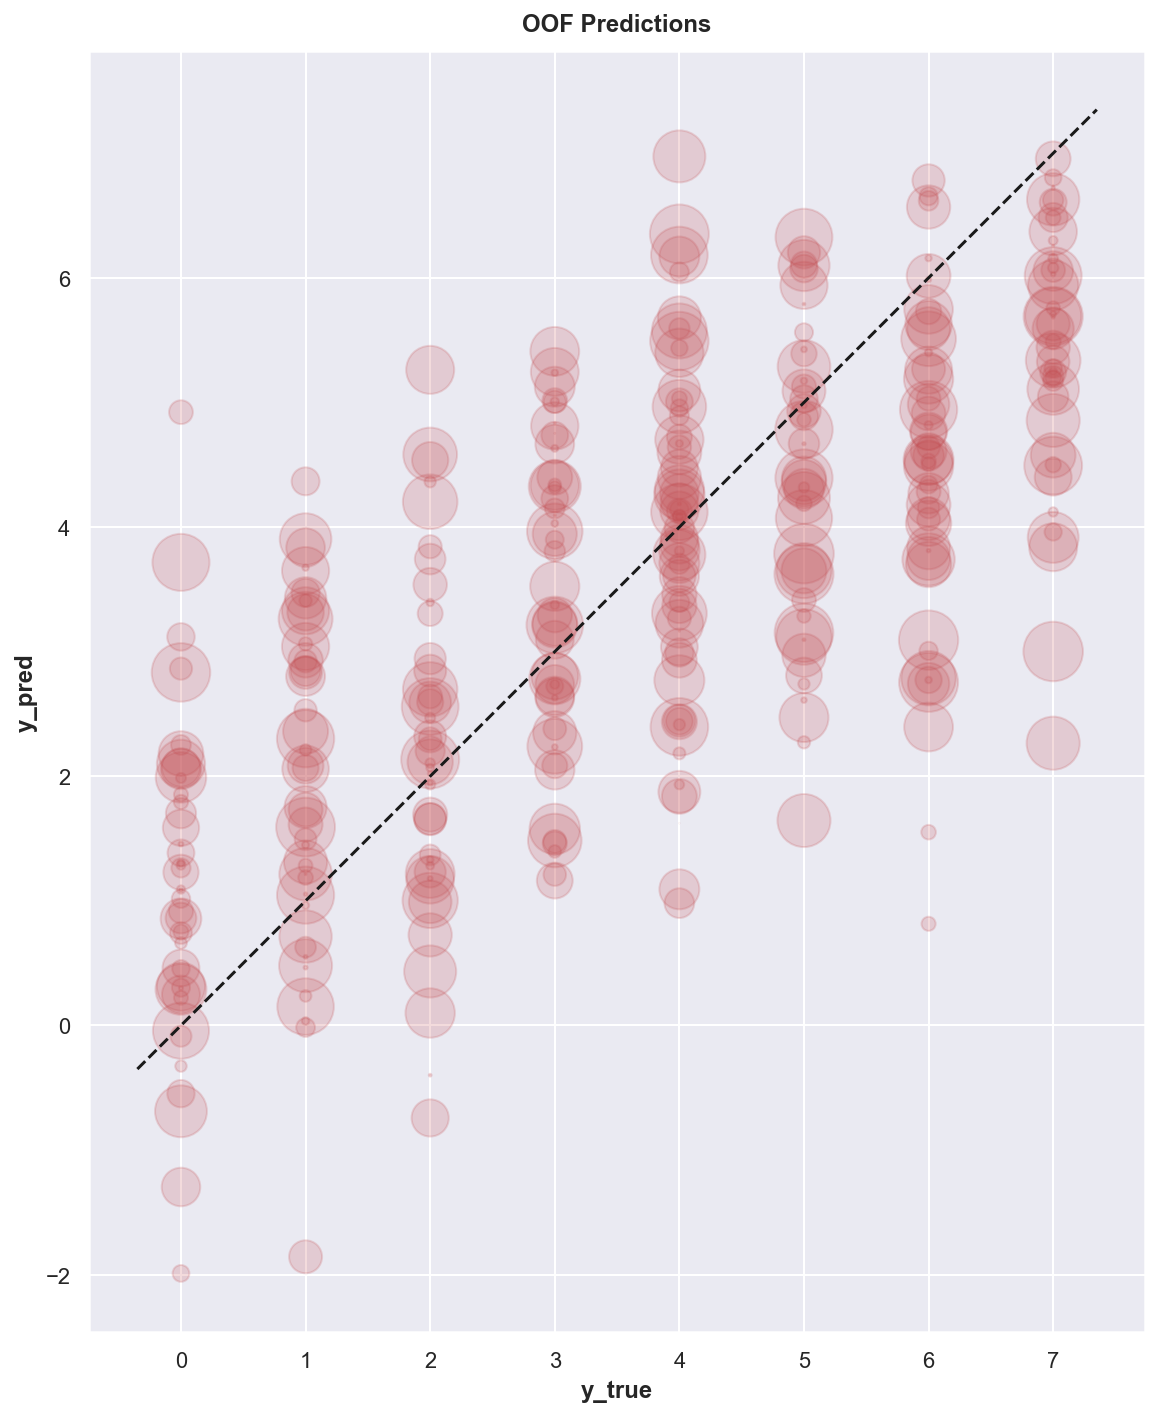

In [870]:
plot_oof(y_test, y_pred)

In [871]:
min(y_pred)

-1.990155

In [872]:
mean_absolute_error(y_test, y_pred)

1.2345349231387297

In [873]:
mean_squared_error(y_test, y_pred)

2.3906042823084226

In [874]:
# logistic_regression_pipeline[:-1].get_feature_names_out()
feature_names = logistic_regression_pipeline[:-1].get_feature_names_out()
mdi_importances = pd.Series(
    logistic_regression_pipeline[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

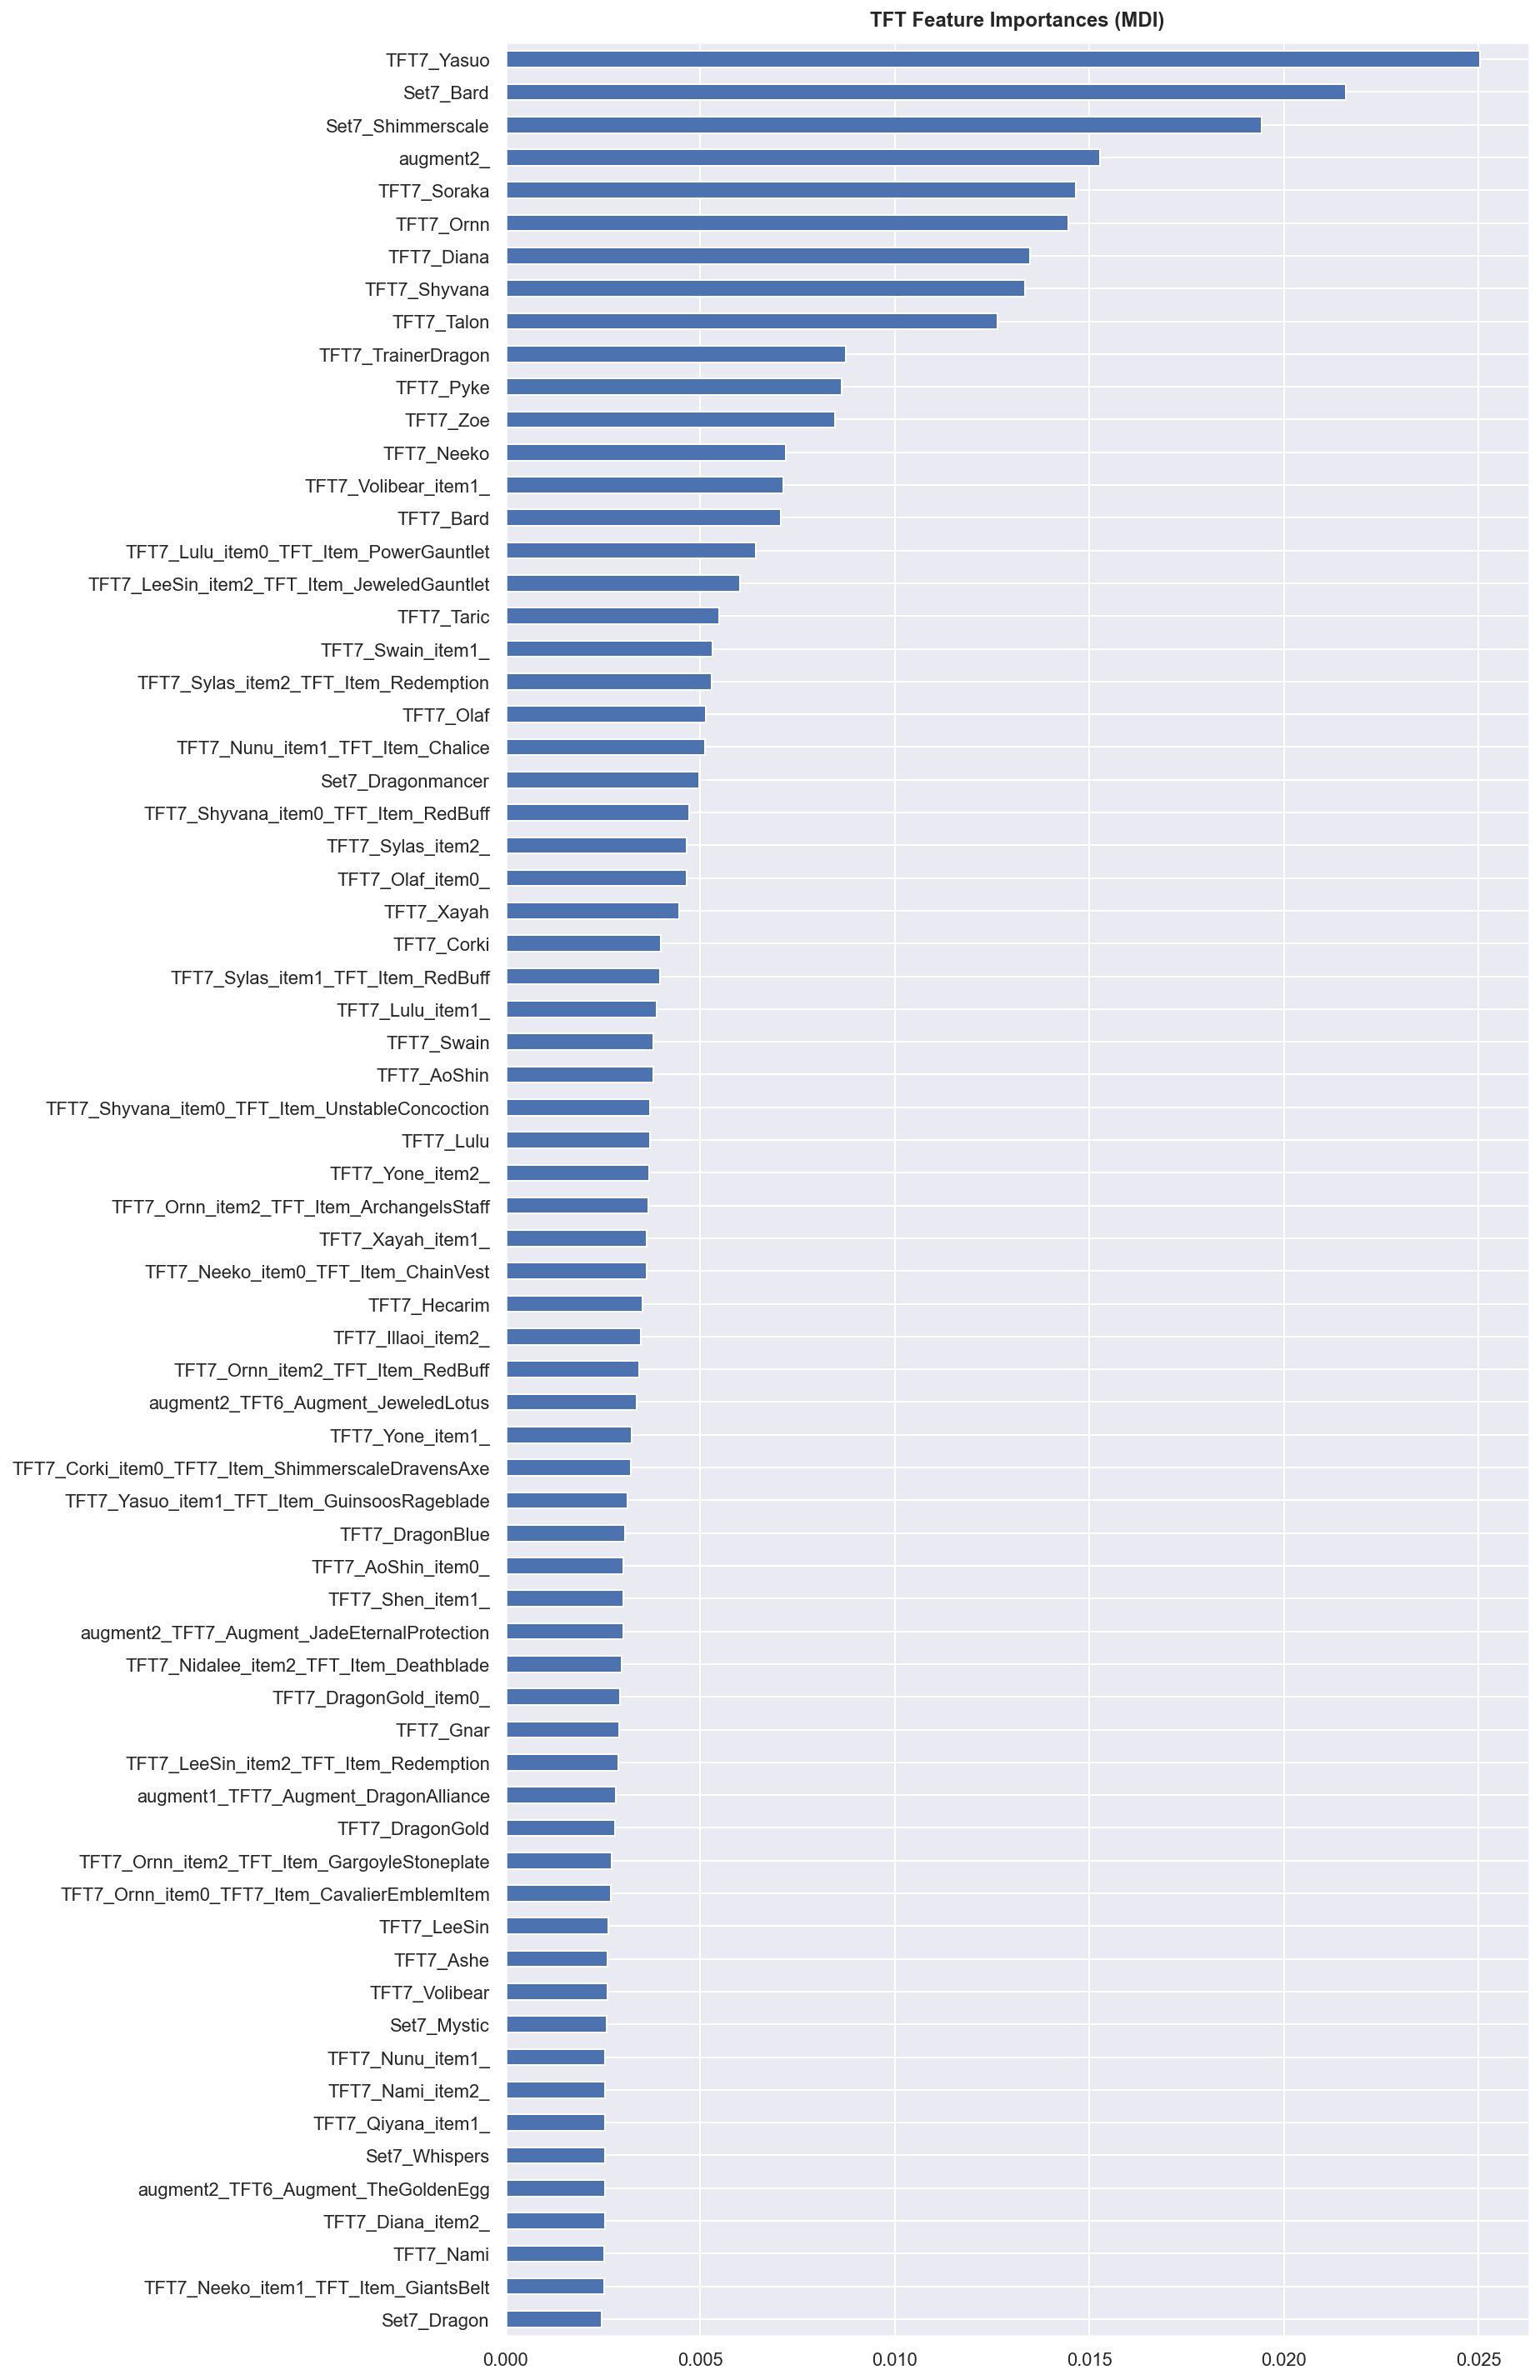

In [875]:
plt.figure(figsize=(13, 20))
ax = mdi_importances[-70:].plot.barh()
ax.set_title("TFT Feature Importances (MDI)")
ax.figure.tight_layout()

In [876]:
mdi_importances.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_mdi_importances.csv'))

In [877]:
mdi_importances[-60:]

TFT7_Volibear                                        0.002608
TFT7_Ashe                                            0.002626
TFT7_LeeSin                                          0.002647
TFT7_Ornn_item0_TFT7_Item_CavalierEmblemItem         0.002704
TFT7_Ornn_item2_TFT_Item_GargoyleStoneplate          0.002717
TFT7_DragonGold                                      0.002811
augment1_TFT7_Augment_DragonAlliance                 0.002834
TFT7_LeeSin_item2_TFT_Item_Redemption                0.002901
TFT7_Gnar                                            0.002916
TFT7_DragonGold_item0_                               0.002943
TFT7_Nidalee_item2_TFT_Item_Deathblade               0.002978
augment2_TFT7_Augment_JadeEternalProtection          0.003015
TFT7_Shen_item1_                                     0.003016
TFT7_AoShin_item0_                                   0.003022
TFT7_DragonBlue                                      0.003056
TFT7_Yasuo_item1_TFT_Item_GuinsoosRageblade          0.003128
TFT7_Cor